# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 8  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

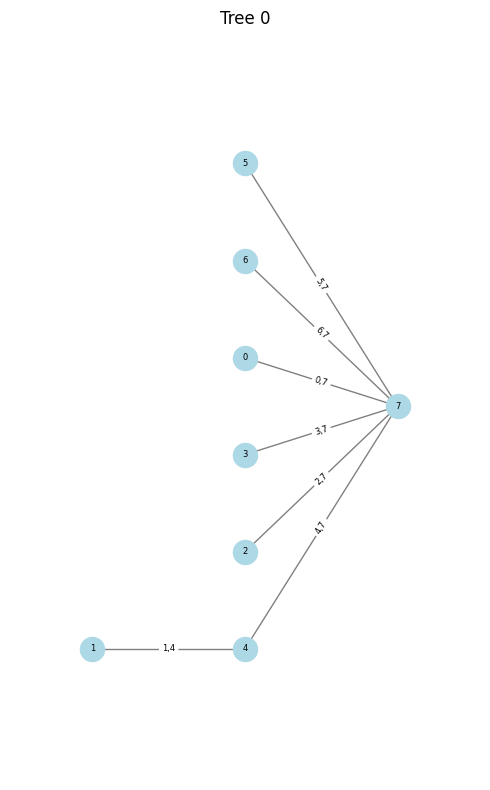

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2026-01-03 16:10:18,173] A new study created in RDB with name: no-name-38d3f652-627c-44df-bd9e-3a21eb8e4f58
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 4/2000 [00:00<02:40, 12.47it/s]

current_loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4315780401229858
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4295238256454468
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4234529733657837
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.418384313583374
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:02, 16.24it/s]

current_loss: tensor(1.4267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4176511764526367
current_loss: tensor(1.4267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4166821241378784
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4165394306182861
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4163851737976074
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4162691831588745
current_loss: tensor(1.4251, 

  1%|          | 13/2000 [00:00<01:57, 16.88it/s]


current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4167371988296509
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4166548252105713
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4167062044143677
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4169515371322632
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4168875217437744
Early Stop at iteration 13 wi

  0%|          | 1/2000 [00:00<06:23,  5.22it/s]

current_loss: tensor(1.4276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3224838972091675
current_loss: tensor(1.3321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.169693946838379
current_loss: tensor(1.1858, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:05,  8.14it/s]

current_loss: tensor(1.4311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.143876075744629
current_loss: tensor(1.1607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1275094747543335
current_loss: tensor(1.1441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1089, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:08, 10.59it/s]

current_loss_val:  1.0874069929122925
current_loss: tensor(1.1089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0751097202301025
current_loss: tensor(1.1002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0683258771896362


  0%|          | 9/2000 [00:00<02:52, 11.56it/s]

current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0527881383895874
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0376405715942383
current_loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.030669927597046


  1%|          | 13/2000 [00:01<02:35, 12.78it/s]

current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.027072787284851
current_loss: tensor(1.0611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.023576021194458
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0191559791564941


  1%|          | 15/2000 [00:01<02:32, 13.01it/s]

current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0146522521972656
current_loss: tensor(1.0392, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0079023838043213
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0060211420059204


  1%|          | 19/2000 [00:01<02:26, 13.52it/s]

current_loss: tensor(1.0293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.999986469745636
current_loss: tensor(1.0205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9972622394561768
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9948233962059021


  1%|          | 21/2000 [00:01<02:24, 13.67it/s]

current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9928657412528992
current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9900696277618408
current_loss: tensor(1.0094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9866975545883179


  1%|          | 23/2000 [00:01<02:23, 13.77it/s]

current_loss: tensor(1.0050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9841039180755615
current_loss: tensor(1.0028, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9818297624588013
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9795259833335876


  1%|▏         | 27/2000 [00:02<02:23, 13.74it/s]

current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.976307213306427
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702808260917664
current_loss: tensor(0.9905, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659600853919983


  1%|▏         | 29/2000 [00:02<02:23, 13.76it/s]

current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9634665250778198
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596222639083862
current_loss: tensor(0.9821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:27, 13.37it/s]

current_loss_val:  0.9563552737236023
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552537798881531
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533231854438782
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9849, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:31, 12.94it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515582919120789
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497101902961731
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9461721777915955
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:25, 13.44it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9450605511665344
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444112181663513
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9434829950332642
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:30, 12.98it/s]

current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423373937606812
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9407256245613098
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9399226307868958


  2%|▏         | 43/2000 [00:03<02:27, 13.26it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9385977387428284
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9381985068321228
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:36, 12.52it/s]

current_loss_val:  0.9377390742301941
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9366121292114258
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935970664024353
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:03<02:30, 12.94it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9356846809387207
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9349172711372375
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9339058995246887
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:32, 12.76it/s]

current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9332082867622375
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9316084384918213
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9314818978309631


  3%|▎         | 55/2000 [00:04<02:28, 13.14it/s]

current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9313380718231201
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.929693877696991
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9298552870750427


  3%|▎         | 57/2000 [00:04<02:25, 13.35it/s]

current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9287945032119751
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277951121330261
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:23, 13.53it/s]

current_loss_val:  0.926917552947998
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266149401664734
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263426661491394
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:21, 13.66it/s]

current_loss_val:  0.9258561134338379
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9241654276847839
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.923511803150177
current_loss: tensor(0.9431, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:23, 13.50it/s]

current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226722717285156
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9217332005500793
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9207006096839905
current_loss: tensor(0.9407, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:05<02:21, 13.66it/s]

current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9200317859649658
current_loss: tensor(0.9400, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9194410443305969
current_loss: tensor(0.9393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9180377125740051
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:19, 13.82it/s]

current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916849672794342
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916225790977478
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9147204756736755
current_loss: tensor(0.9354, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 75/2000 [00:05<02:28, 13.00it/s]

current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9145572781562805
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9142755270004272
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:05<02:32, 12.59it/s]

current_loss_val:  0.9132488369941711
current_loss: tensor(0.9332, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9350, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130884408950806
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9130479097366333
current_loss: tensor(0.9328, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<02:31, 12.64it/s]

current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9128686785697937
current_loss: tensor(0.9317, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9124510288238525
current_loss: tensor(0.9313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121594429016113


  4%|▍         | 83/2000 [00:06<02:27, 13.04it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119915962219238
current_loss: tensor(0.9307, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118643403053284
current_loss: tensor(0.9302, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120590090751648


  4%|▍         | 87/2000 [00:06<02:21, 13.55it/s]

current_loss: tensor(0.9301, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116033315658569
current_loss: tensor(0.9297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114799499511719
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113039970397949


  4%|▍         | 89/2000 [00:06<02:26, 13.07it/s]

current_loss: tensor(0.9294, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9298, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113221168518066
current_loss: tensor(0.9293, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112748503684998
current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 91/2000 [00:07<02:25, 13.12it/s]

current_loss_val:  0.9112359881401062
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113247394561768
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911212682723999
current_loss: tensor(0.9288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 95/2000 [00:07<02:20, 13.55it/s]

current_loss_val:  0.9112210869789124
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112377166748047
current_loss: tensor(0.9287, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113579392433167
current_loss: tensor(0.9284, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:27, 12.88it/s]


current_loss_val:  0.911503791809082
current_loss: tensor(0.9279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9274, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112462997436523
Early Stop at iteration 96 with minimal loss tensor(0.9112, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:28,797] Trial 0 finished with value: -7.289700984954834 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.313211190578067, 'penalty_decorrelation_ridge_second_difference': 23.63504255108578}. Best is trial 0 with value: -7.289700984954834.
  0%|          | 2/2000 [00:00<02:24, 13.83it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114949107170105
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112739562988281
current_loss: tensor(0.9108, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111648201942444


  0%|          | 4/2000 [00:00<02:21, 14.11it/s]

current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111407399177551
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112191796302795
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:22,  9.83it/s]

current_loss_val:  0.9142255187034607
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9139495491981506
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9134247303009033
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:33,  9.32it/s]


current_loss_val:  0.9126842021942139
Early Stop at iteration 8 with minimal loss tensor(0.9111, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:30,278] Trial 1 finished with value: -7.289125442504883 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.4412552811960215, 'penalty_decorrelation_ridge_second_difference': 1.3916168578605268}. Best is trial 1 with value: -7.289125442504883.
  0%|          | 2/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115608334541321
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114153385162354
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114692807197571


  0%|          | 4/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117966294288635
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9143456220626831
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:56, 11.29it/s]

current_loss_val:  0.914989173412323
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9151408672332764
Early Stop at iteration 6 with minimal loss tensor(0.9114, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:10:31,460] Trial 2 finished with value: -7.291322231292725 and parameters: {'penalty_decorrelation_ridge_first_difference': 22.329700749875265, 'penalty_decorrelation_ridge_second_difference': 5.8383517254440624}. Best is trial 1 with value: -7.289125442504883.
  0%|          | 2/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112523198127747
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113141298294067
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:59, 11.11it/s]

current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114779233932495
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112450480461121
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110578298568726


  0%|          | 6/2000 [00:00<02:45, 12.04it/s]

current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110192060470581
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112147092819214
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911151647567749


  0%|          | 10/2000 [00:00<02:31, 13.14it/s]

current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110033512115479
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105924367904663
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102756977081299


  1%|          | 14/2000 [00:01<02:25, 13.64it/s]

current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101364016532898
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100006818771362
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098919034004211


  1%|          | 16/2000 [00:01<02:24, 13.75it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097838401794434
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095513224601746
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094327688217163


  1%|          | 20/2000 [00:01<02:22, 13.85it/s]

current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093632102012634
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092450141906738
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091691374778748


  1%|          | 22/2000 [00:01<02:29, 13.22it/s]

current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908777117729187
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087293148040771
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9189, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:40, 12.34it/s]

current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908500611782074
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9077701568603516
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074033498764038


  1%|▏         | 28/2000 [00:02<02:35, 12.66it/s]

current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073479175567627
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073619842529297
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907346785068512


  2%|▏         | 30/2000 [00:02<02:38, 12.47it/s]

current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074738025665283
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074822068214417
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:33, 12.85it/s]

current_loss_val:  0.9074804186820984
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074220657348633
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067750573158264
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:46, 11.83it/s]

current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066000580787659
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065641760826111
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:35, 12.64it/s]

current_loss_val:  0.9065237045288086
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065751433372498
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066200256347656
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:37, 12.48it/s]

current_loss_val:  0.9066985249519348
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067139625549316
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067237973213196
Early Stop at iteration 40 with minimal loss tensor(0.9065, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:10:35,320] Trial 3 finished with value: -7.252189636230469 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.801909752414342, 'penalty_decorrelation_ridge_second_difference': 5.498650789301144}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 1/2000 [00:00<07:04,  4.71it/s]

current_loss: tensor(0.9311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9312, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112400412559509


  0%|          | 3/2000 [00:00<03:42,  8.96it/s]

current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112421274185181
current_loss: tensor(0.9310, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114127159118652
current_loss: tensor(0.9305, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:53,  8.53it/s]

current_loss_val:  0.911745548248291
current_loss: tensor(0.9300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114479422569275
current_loss: tensor(0.9296, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113481640815735
Early Stop at iteration 5 with minimal loss tensor(0.9112, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:10:36,595] Trial 4 finished with value: -7.289919376373291 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.271268713033084, 'penalty_decorrelation_ridge_second_difference': 27.540036162886636}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<02:23, 13.96it/s]

current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115475416183472
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113254547119141
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112561345100403


  0%|          | 4/2000 [00:00<03:24,  9.75it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112690687179565
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:07, 10.66it/s]

current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115928411483765
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9132211208343506
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0007, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:28,  9.56it/s]


current_loss_val:  0.9137015342712402
current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9138461351394653
Early Stop at iteration 7 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:37,916] Trial 5 finished with value: -7.290048122406006 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.439803777209098, 'penalty_decorrelation_ridge_second_difference': 21.51719353709202}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<03:11, 10.44it/s]

current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112760424613953
current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117001891136169
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:42, 12.27it/s]

current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118757843971252
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911824643611908
current_loss: tensor(0.9319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120725393295288
current_loss: tensor(0.9316, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:10, 10.45it/s]


current_loss: tensor(0.9314, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121782779693604
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:39,097] Trial 6 finished with value: -7.290208339691162 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.707686948184117, 'penalty_decorrelation_ridge_second_difference': 1.4162636978182652}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:51,  2.81it/s]

current_loss_val:  0.9115288853645325
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:02,  3.32it/s]

current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118442535400391
current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9168784618377686
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:12,  5.36it/s]

current_loss_val:  0.9176735877990723
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9178205132484436
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190775752067566
Early Stop at iteration 5 with minimal loss tensor(0.9115, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:10:40,906] Trial 7 finished with value: -7.292231559753418 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.635574075490467, 'penalty_decorrelation_ridge_second_difference': 21.3033248782006}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 1/2000 [00:00<06:03,  5.50it/s]

current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115076065063477
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119430184364319
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:01, 11.00it/s]

current_loss_val:  0.9164166450500488
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9172897934913635
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9174795150756836
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:43,  8.94it/s]


current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9190182089805603
Early Stop at iteration 5 with minimal loss tensor(0.9115, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:42,169] Trial 8 finished with value: -7.292060375213623 and parameters: {'penalty_decorrelation_ridge_first_difference': 27.301473139049797, 'penalty_decorrelation_ridge_second_difference': 22.95446011795218}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 3/2000 [00:00<02:51, 11.63it/s]

current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115473031997681
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113360047340393
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112616181373596


  0%|          | 5/2000 [00:00<02:36, 12.74it/s]

current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112853407859802
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117040038108826
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9137940406799316


  0%|          | 7/2000 [00:00<03:00, 11.06it/s]

current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.915804386138916
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9149319529533386
Early Stop at iteration 7 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:10:43,412] Trial 9 finished with value: -7.290092945098877 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.622009755369284, 'penalty_decorrelation_ridge_second_difference': 26.934878512199475}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<03:11, 10.41it/s]

current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112865328788757
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116626381874084
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.24it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121708273887634
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121935367584229
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9121395945549011


  0%|          | 5/2000 [00:00<03:22,  9.85it/s]


current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91277015209198
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:44,523] Trial 10 finished with value: -7.290291786193848 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.0660197337412, 'penalty_decorrelation_ridge_second_difference': 10.78570795477883}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<02:47, 11.94it/s]

current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112436175346375
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911247193813324
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.94it/s]

current_loss_val:  0.9114865660667419
current_loss: tensor(0.9346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120126962661743
current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117431044578552
current_loss: tensor(0.9334, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:03, 10.85it/s]


current_loss_val:  0.9116565585136414
Early Stop at iteration 5 with minimal loss tensor(0.9112, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:45,584] Trial 11 finished with value: -7.2899489402771 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.959014683210545, 'penalty_decorrelation_ridge_second_difference': 16.719997018265794}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 1/2000 [00:00<04:38,  7.18it/s]

current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115700721740723
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:22,  6.19it/s]

current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9146003723144531
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:28,  6.08it/s]

current_loss_val:  0.9179369211196899
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9191124439239502
current_loss: tensor(0.9634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:03,  6.57it/s]

current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920011043548584
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.922174334526062
Early Stop at iteration 5 with minimal loss tensor(0.9116, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 5/2000 [00:00<06:15,  5.31it/s]
[I 2026-01-03 16:10:47,195] Trial 12 finished with value: -7.292560577392578 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.651019842222187, 'penalty_decorrelation_ridge_second_difference': 6.374084254997828}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<02:25, 13.72it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115118980407715
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118803143501282
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9156408905982971


  0%|          | 4/2000 [00:00<02:37, 12.64it/s]

current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9163833856582642
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.916466474533081
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:03, 10.88it/s]


current_loss_val:  0.9183945059776306
Early Stop at iteration 5 with minimal loss tensor(0.9115, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:48,238] Trial 13 finished with value: -7.292094707489014 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.827182115974676, 'penalty_decorrelation_ridge_second_difference': 28.9422453020344}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 1/2000 [00:00<03:24,  9.77it/s]

current_loss: tensor(0.9441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112828969955444
current_loss: tensor(0.9440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116308093070984
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:50, 11.67it/s]

current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120013117790222
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117924571037292
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9117342829704285


  0%|          | 5/2000 [00:00<03:23,  9.82it/s]


current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9406, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9120193719863892
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:49,421] Trial 14 finished with value: -7.290262699127197 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.83774957152894, 'penalty_decorrelation_ridge_second_difference': 5.446146988898629}. Best is trial 3 with value: -7.252189636230469.
  0%|          | 2/2000 [00:00<03:10, 10.47it/s]

current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112572073936462
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115191698074341
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.12it/s]

current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114850163459778
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112186431884766
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113209843635559
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.09it/s]

current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114512801170349
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113291501998901
current_loss: tensor(0.9091, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107312560081482
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:38, 12.59it/s]

current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105326533317566
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910295844078064
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100501537322998


  1%|          | 14/2000 [00:01<02:29, 13.27it/s]

current_loss: tensor(0.9079, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098953008651733
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101714491844177
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098906517028809


  1%|          | 16/2000 [00:01<02:27, 13.45it/s]

current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098088145256042
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096066355705261
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093363285064697


  1%|          | 18/2000 [00:01<02:27, 13.47it/s]

current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909325122833252
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092077612876892
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090644717216492


  1%|          | 22/2000 [00:01<02:26, 13.46it/s]

current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089617133140564
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088655114173889
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:32, 12.94it/s]

current_loss_val:  0.9087538123130798
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087709784507751
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087492823600769
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:29, 13.19it/s]

current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086722731590271
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086009860038757
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<04:20,  7.57it/s]

current_loss_val:  0.9085265398025513
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<04:59,  6.59it/s]

current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085110425949097
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084022641181946


  2%|▏         | 32/2000 [00:03<04:14,  7.74it/s]

current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081398248672485
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075956344604492
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<03:41,  8.87it/s]

current_loss_val:  0.9071968793869019
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068114161491394
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064255952835083
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<03:04, 10.65it/s]

current_loss_val:  0.9056450724601746
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052081108093262
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049876928329468
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:51, 11.40it/s]

current_loss_val:  0.9048852324485779
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.90467768907547
current_loss: tensor(0.9031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046815633773804
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:42, 12.04it/s]

current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047023057937622
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047743082046509
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050719738006592
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:04<03:00, 10.86it/s]


current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9048960208892822
Early Stop at iteration 44 with minimal loss tensor(0.9047, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:54,148] Trial 15 finished with value: -7.237421035766602 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.4942865534590357, 'penalty_decorrelation_ridge_second_difference': 6.279584061534456}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 2/2000 [00:00<02:49, 11.82it/s]

current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911231517791748
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112246036529541
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:33, 13.03it/s]

current_loss_val:  0.9112460017204285
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113321900367737
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109211564064026
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9108455181121826
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107654094696045
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107035398483276
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:27, 13.47it/s]

current_loss_val:  0.9106483459472656
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104917049407959
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102163910865784
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:26, 13.55it/s]

current_loss_val:  0.9100748300552368
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9099575281143188
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097109436988831
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:25, 13.65it/s]

current_loss_val:  0.9094934463500977
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093856811523438
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093735218048096
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:34, 12.85it/s]

current_loss_val:  0.909358561038971
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093278646469116
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093454480171204
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:37, 12.55it/s]

current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909416675567627
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094247817993164
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094042181968689


  1%|          | 23/2000 [00:01<02:37, 12.56it/s]


current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093554019927979
Early Stop at iteration 23 with minimal loss tensor(0.9093, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:10:56,732] Trial 16 finished with value: -7.274622440338135 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.6053479164219961, 'penalty_decorrelation_ridge_second_difference': 13.646265887179649}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 2/2000 [00:00<02:46, 12.00it/s]

current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112462997436523
current_loss: tensor(0.9249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112433195114136
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:51, 11.67it/s]

current_loss_val:  0.9114149808883667
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9113895297050476
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111940264701843
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:37, 12.66it/s]

current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111253619194031
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112182259559631
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111036658287048
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:32, 13.06it/s]

current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109494090080261
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9104637503623962
current_loss: tensor(0.9227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098526835441589
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.33it/s]

current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9099082350730896
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097667932510376
current_loss: tensor(0.9218, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909521758556366
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.31it/s]

current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093304872512817
current_loss: tensor(0.9215, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092605710029602
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092191457748413
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:38, 12.49it/s]

current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092312455177307
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091396927833557
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9087467193603516


  1%|          | 22/2000 [00:01<02:39, 12.39it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085159301757812
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084154367446899
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:35, 12.73it/s]

current_loss_val:  0.9082353711128235
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079753756523132
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9078304171562195
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:29, 13.16it/s]

current_loss_val:  0.907724142074585
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076325297355652
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076077938079834
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:27, 13.37it/s]

current_loss_val:  0.9075530171394348
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075631499290466
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074007868766785
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:26, 13.41it/s]

current_loss_val:  0.9072766304016113
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907314121723175
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:38, 12.41it/s]

current_loss_val:  0.9072238206863403
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070042967796326
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069086313247681
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:33, 12.77it/s]

current_loss_val:  0.9068925976753235
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068102836608887
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067871570587158
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:41, 12.12it/s]

current_loss_val:  0.9067598581314087
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067108631134033
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066960215568542


  2%|▏         | 44/2000 [00:03<02:42, 12.03it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067614674568176
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066564440727234
current_loss: tensor(0.9166, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:36, 12.51it/s]

current_loss_val:  0.9065602421760559
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063200354576111
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063200354576111
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:36, 12.45it/s]

current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906322181224823
current_loss: tensor(0.9163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906313419342041
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061659574508667
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:32, 12.80it/s]

current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057521820068359
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056631326675415
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056459665298462
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:28, 13.08it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056689739227295
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9055077433586121
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.81it/s]

current_loss_val:  0.9054852724075317
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054874777793884
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056336879730225
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:27, 13.14it/s]

current_loss_val:  0.9056653380393982
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057096838951111


  3%|▎         | 60/2000 [00:05<02:41, 11.99it/s]

current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058963060379028
Early Stop at iteration 60 with minimal loss tensor(0.9055, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:11:02,530] Trial 17 finished with value: -7.243881702423096 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.937152573668262, 'penalty_decorrelation_ridge_second_difference': 7.403081723741542}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 2/2000 [00:00<03:11, 10.43it/s]

current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112554788589478
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115049839019775
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.11it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114543199539185
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111784100532532
current_loss: tensor(0.9090, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112557768821716
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:33, 12.94it/s]

current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911392092704773
current_loss: tensor(0.9086, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112491607666016
current_loss: tensor(0.9085, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107295274734497
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:31, 13.17it/s]

current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100884199142456
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909844160079956
current_loss: tensor(0.9073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098188281059265
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:28, 13.40it/s]

current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096212387084961
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094767570495605
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:33, 12.95it/s]

current_loss_val:  0.909490168094635
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093596339225769
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092739224433899
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.25it/s]

current_loss_val:  0.9092938303947449
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091836214065552
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091340899467468
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:35, 12.69it/s]

current_loss_val:  0.908939778804779
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086573123931885
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085994958877563
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:32, 12.98it/s]

current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084866046905518
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9083097577095032
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081582427024841
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:28, 13.28it/s]

current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080854654312134
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080339074134827
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079616069793701
current_loss: tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:34, 12.76it/s]

current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9078350067138672
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9077569842338562
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:40, 12.29it/s]

current_loss_val:  0.907541036605835
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074441194534302
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073649048805237


  2%|▏         | 34/2000 [00:02<02:45, 11.89it/s]

current_loss: tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067981243133545
current_loss: tensor(0.9030, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064798951148987
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:35, 12.66it/s]

current_loss_val:  0.9062452912330627
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062091708183289
current_loss: tensor(0.9026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061809182167053
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:32, 12.82it/s]

current_loss_val:  0.9062750339508057
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063488245010376
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064623713493347
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:36, 12.51it/s]

current_loss_val:  0.9063228368759155
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062288403511047
Early Stop at iteration 42 with minimal loss tensor(0.9062, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:11:06,748] Trial 18 finished with value: -7.249446868896484 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.008726902644348278, 'penalty_decorrelation_ridge_second_difference': 6.91023610401068}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 2/2000 [00:00<02:46, 12.02it/s]

current_loss: tensor(0.9291, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112355709075928
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911235511302948
current_loss: tensor(0.9290, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:32, 13.06it/s]

current_loss_val:  0.9113479852676392
current_loss: tensor(0.9286, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115579128265381
current_loss: tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112246632575989
current_loss: tensor(0.9280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:31, 13.12it/s]

current_loss_val:  0.911077082157135
current_loss: tensor(0.9278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.91111159324646
current_loss: tensor(0.9275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9110782146453857
current_loss: tensor(0.9272, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.37it/s]

current_loss_val:  0.911048173904419
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109018445014954
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101410508155823
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.44it/s]

current_loss_val:  0.9100960493087769
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100832939147949
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102234244346619
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.54it/s]

current_loss_val:  0.9105131030082703
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910264790058136
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101865887641907
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:28, 13.31it/s]

current_loss_val:  0.9100669622421265
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098949432373047
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909862756729126
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:27, 13.42it/s]

current_loss_val:  0.9098624587059021
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098622798919678
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909875750541687
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:27, 13.42it/s]

current_loss_val:  0.9099077582359314
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098621606826782
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096866846084595
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:33, 12.88it/s]

current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095534086227417
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094389081001282
current_loss: tensor(0.9238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093143939971924
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:28, 13.23it/s]

current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092531800270081
current_loss: tensor(0.9237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091757535934448
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090051651000977
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:36, 12.56it/s]

current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088150858879089
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086445569992065
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084649085998535
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:31, 12.92it/s]

current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9083253741264343
current_loss: tensor(0.9223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9083098769187927
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908243715763092
current_loss: 

  2%|▏         | 40/2000 [00:03<02:28, 13.23it/s]

tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082391262054443
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082300066947937
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:36, 12.49it/s]

current_loss_val:  0.9079773426055908
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076448678970337
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9072307348251343
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:31, 12.89it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070601463317871
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066069722175598
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062537550926208
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:28, 13.10it/s]

current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906012237071991
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057430028915405
current_loss: tensor(0.9190, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054657816886902
current_loss: tensor(0.9188, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:27, 13.22it/s]

current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052252173423767
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050771594047546
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050673842430115
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:26, 13.27it/s]

current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050942063331604
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057766795158386
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9053018093109131
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:24, 13.48it/s]

current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052063822746277
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050315022468567
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049527049064636
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:23, 13.54it/s]

current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049259424209595
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904928982257843
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049406051635742
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:28, 13.02it/s]

current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050155282020569
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050717949867249
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905037522315979
Early Stop at iteration 63 with minimal loss tensor(0.9049, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:11:12,380] Trial 19 finished with value: -7.239407062530518 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.783152471257731, 'penalty_decorrelation_ridge_second_difference': 14.779335460689653}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 1/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(0.9344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9345, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112438559532166
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112468361854553
current_loss: tensor(0.9343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:33, 12.97it/s]

current_loss_val:  0.9114680886268616
current_loss: tensor(0.9337, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9119359850883484
current_loss: tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115390777587891
current_loss: tensor(0.9329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:05, 10.73it/s]


current_loss_val:  0.9113935828208923
Early Stop at iteration 5 with minimal loss tensor(0.9112, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:13,462] Trial 20 finished with value: -7.289950370788574 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.32253406797991, 'penalty_decorrelation_ridge_second_difference': 13.978147950595748}. Best is trial 15 with value: -7.237421035766602.
  0%|          | 1/2000 [00:00<03:23,  9.82it/s]

current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9271, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911237895488739
current_loss: tensor(0.9270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112364053726196
current_loss: tensor(0.9269, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:32, 13.05it/s]

current_loss_val:  0.9113484025001526
current_loss: tensor(0.9265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115930795669556
current_loss: tensor(0.9263, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111575484275818
current_loss: tensor(0.9260, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:30, 13.28it/s]

current_loss_val:  0.9110710620880127
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109784364700317
current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109268188476562
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:28, 13.35it/s]

current_loss_val:  0.9108601212501526
current_loss: tensor(0.9256, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106428623199463
current_loss: tensor(0.9255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103313088417053
current_loss: tensor(0.9254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:27, 13.43it/s]

current_loss_val:  0.9102783203125
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102706909179688
current_loss: tensor(0.9253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102599024772644
current_loss: tensor(0.9250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:29, 13.25it/s]

current_loss_val:  0.9105510115623474
current_loss: tensor(0.9248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102312326431274
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910140872001648
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:31, 13.06it/s]

current_loss_val:  0.9099847078323364
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097485542297363
current_loss: tensor(0.9236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096924662590027
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:30, 13.14it/s]

current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096428751945496
current_loss: tensor(0.9234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095852375030518
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095797538757324
current_loss: 

  1%|▏         | 25/2000 [00:01<02:30, 13.10it/s]

tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095381498336792
current_loss: tensor(0.9231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094802737236023
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:29, 13.22it/s]

current_loss_val:  0.9094549417495728
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909444272518158
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909445583820343
current_loss: tensor(0.9230, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:32, 12.89it/s]

current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095221161842346
current_loss: tensor(0.9228, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094635844230652
current_loss: tensor(0.9226, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096315503120422


  2%|▏         | 33/2000 [00:02<02:29, 13.12it/s]

current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092252850532532
current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091026782989502
current_loss: tensor(0.9219, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:34, 12.71it/s]

current_loss_val:  0.9084625840187073
current_loss: tensor(0.9213, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9214, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081855416297913
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908115565776825
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:02<02:31, 12.94it/s]

current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907874584197998
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075800180435181
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9072846174240112
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:28, 13.16it/s]

current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907313883304596
current_loss: tensor(0.9194, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074314832687378
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075333476066589
current_loss: tensor(0.9187, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:26, 13.30it/s]

current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9071582555770874
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907107949256897
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070925712585449
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:25, 13.43it/s]

current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069977402687073
current_loss: tensor(0.9185, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068949222564697
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068149924278259
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:25, 13.44it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066011309623718
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065390229225159
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064361453056335


  3%|▎         | 53/2000 [00:04<02:21, 13.72it/s]

current_loss: tensor(0.9182, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064826965332031
current_loss: tensor(0.9181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064476490020752
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063340425491333


  3%|▎         | 55/2000 [00:04<02:21, 13.77it/s]

current_loss: tensor(0.9179, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061501026153564
current_loss: tensor(0.9178, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061592221260071
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:23, 13.57it/s]

current_loss_val:  0.9062098264694214
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061838984489441
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9060259461402893
current_loss: tensor(0.9175, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:22, 13.57it/s]

current_loss_val:  0.9059990644454956
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9059287905693054
current_loss: tensor(0.9174, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058161377906799
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:30, 12.83it/s]

current_loss_val:  0.905704140663147
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9172, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9055765867233276
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054945707321167
current_loss: tensor(0.9170, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:27, 13.09it/s]

current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054872393608093
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9054964780807495
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9055153131484985
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:25, 13.24it/s]

current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905399739742279
current_loss: tensor(0.9165, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052821397781372
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052183032035828
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:24, 13.35it/s]

current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051722884178162
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050629138946533
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9050670862197876
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 77/2000 [00:05<02:23, 13.44it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049845933914185
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904948890209198
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049049019813538


  4%|▍         | 79/2000 [00:05<02:29, 12.87it/s]

current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9048912525177002
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9048540592193604
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 81/2000 [00:06<02:34, 12.38it/s]

current_loss_val:  0.9047926664352417
current_loss: tensor(0.9155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9156, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047547578811646
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047344923019409
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 83/2000 [00:06<02:30, 12.70it/s]

current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047511219978333
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047310948371887
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 87/2000 [00:06<02:30, 12.69it/s]

current_loss_val:  0.9047152996063232
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047090411186218
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047123193740845
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9153, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 89/2000 [00:06<02:33, 12.42it/s]

current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047308564186096
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047232866287231
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047079682350159
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 93/2000 [00:07<02:28, 12.87it/s]

current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904667854309082
current_loss: tensor(0.9151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046053886413574
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044733643531799


  5%|▍         | 95/2000 [00:07<02:25, 13.09it/s]

current_loss: tensor(0.9150, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043612480163574
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904227077960968
current_loss: tensor(0.9148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 97/2000 [00:07<02:28, 12.78it/s]

current_loss_val:  0.9041688442230225
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041269421577454
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041548371315002
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 101/2000 [00:07<02:24, 13.11it/s]

current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041947722434998
current_loss: tensor(0.9145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041270613670349
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041159152984619
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 103/2000 [00:07<02:23, 13.26it/s]

current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040908813476562
current_loss: tensor(0.9143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040181040763855
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040319323539734
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 107/2000 [00:08<02:19, 13.59it/s]

current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040054082870483
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039736986160278
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039957523345947
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 109/2000 [00:08<02:20, 13.42it/s]

current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.903987467288971
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9039976000785828
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9140, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:08<02:25, 13.00it/s]


current_loss_val:  0.9040052890777588
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040018320083618
Early Stop at iteration 110 with minimal loss tensor(0.9040, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:22,545] Trial 21 finished with value: -7.231789588928223 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.725853791745607, 'penalty_decorrelation_ridge_second_difference': 11.636270232528835}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 2/2000 [00:00<02:48, 11.85it/s]

current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112271070480347
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112230539321899
current_loss: tensor(0.9205, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:34, 12.88it/s]

current_loss_val:  0.9112428426742554
current_loss: tensor(0.9203, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112478494644165
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109430313110352
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:28, 13.43it/s]

current_loss_val:  0.9107623100280762
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107463955879211
current_loss: tensor(0.9195, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106003642082214
current_loss: tensor(0.9193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.24it/s]

current_loss_val:  0.9104993343353271
current_loss: tensor(0.9191, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098106026649475
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909397542476654


  1%|          | 12/2000 [00:00<02:40, 12.36it/s]

current_loss: tensor(0.9184, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092990159988403
current_loss: tensor(0.9183, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091671109199524
current_loss: tensor(0.9180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:32, 12.99it/s]

current_loss_val:  0.9092367887496948
current_loss: tensor(0.9177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092151522636414
current_loss: tensor(0.9176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090359210968018
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:29, 13.25it/s]

current_loss_val:  0.9090396165847778
current_loss: tensor(0.9173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090393781661987
current_loss: tensor(0.9171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088761210441589
current_loss: tensor(0.9169, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:28, 13.34it/s]

current_loss_val:  0.9086791276931763
current_loss: tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908427357673645
current_loss: tensor(0.9167, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082410335540771
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.38it/s]

current_loss_val:  0.9082306623458862
current_loss: tensor(0.9164, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.90803062915802
current_loss: tensor(0.9162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080045223236084
current_loss: tensor(0.9161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:28, 13.30it/s]

current_loss_val:  0.9080184102058411
current_loss: tensor(0.9160, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082367420196533
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081588387489319
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:34, 12.75it/s]


current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081217646598816
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908067524433136
Early Stop at iteration 29 with minimal loss tensor(0.9080, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:25,422] Trial 22 finished with value: -7.264035701751709 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.3888115105024141, 'penalty_decorrelation_ridge_second_difference': 17.343527602598755}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 2/2000 [00:00<02:53, 11.53it/s]

current_loss: tensor(0.9258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9259, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112396836280823
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112374186515808
current_loss: tensor(0.9257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:36, 12.72it/s]

current_loss_val:  0.9113552570343018
current_loss: tensor(0.9252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116577506065369
current_loss: tensor(0.9251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111412763595581
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:32, 13.11it/s]

current_loss_val:  0.9110773205757141
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910998523235321
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:25,  9.68it/s]

current_loss_val:  0.9108991026878357
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108472466468811
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107896089553833
current_loss: tensor(0.9244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:05, 10.72it/s]

current_loss_val:  0.9106833934783936
current_loss: tensor(0.9243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9103501439094543
current_loss: tensor(0.9242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9102706909179688
current_loss: tensor(0.9241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:45, 11.98it/s]

current_loss_val:  0.9101890325546265
current_loss: tensor(0.9239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9098583459854126
current_loss: tensor(0.9235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909760057926178
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9232, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:53, 11.46it/s]

current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092481732368469
current_loss: tensor(0.9225, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094357490539551
current_loss: tensor(0.9221, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092929363250732
current_loss: tensor(0.9217, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:39, 12.41it/s]

current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092516303062439
current_loss: tensor(0.9216, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.90912264585495
current_loss: tensor(0.9212, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089898467063904
current_loss: tensor(0.9211, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:32, 12.92it/s]

current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088608622550964
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088042378425598
current_loss: tensor(0.9209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086565375328064
current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:40, 12.33it/s]

current_loss: tensor(0.9208, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085028767585754
current_loss: tensor(0.9207, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084298014640808
current_loss: tensor(0.9206, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:33, 12.81it/s]

current_loss_val:  0.9082806706428528
current_loss: tensor(0.9204, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082468748092651
current_loss: tensor(0.9202, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082763195037842
current_loss: tensor(0.9201, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:30, 13.06it/s]

current_loss_val:  0.9081762433052063
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081056118011475
current_loss: tensor(0.9200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9080820679664612
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<02:33, 12.78it/s]

current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082089066505432
current_loss: tensor(0.9198, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082505702972412
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082725048065186
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:47, 11.73it/s]


current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082573652267456
current_loss: tensor(0.9197, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9196, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9082638621330261
Early Stop at iteration 37 with minimal loss tensor(0.9081, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:29,399] Trial 23 finished with value: -7.264656066894531 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.549963329649951, 'penalty_decorrelation_ridge_second_difference': 10.27081735564525}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 2/2000 [00:00<03:11, 10.42it/s]

current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911287784576416
current_loss: tensor(0.9484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114675521850586
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:57, 11.26it/s]

current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9122830629348755
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9131369590759277
current_loss: tensor(0.9450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:24,  9.74it/s]


current_loss_val:  0.9132070541381836
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9141549468040466
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:30,509] Trial 24 finished with value: -7.29030179977417 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.15423985857639, 'penalty_decorrelation_ridge_second_difference': 15.36351041217481}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 1/2000 [00:00<03:22,  9.86it/s]

current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9137, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112415313720703
current_loss: tensor(0.9136, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112319350242615
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:46, 12.00it/s]

current_loss_val:  0.9113099575042725
current_loss: tensor(0.9128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9130, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112167358398438
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.910975456237793
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:36, 12.71it/s]

current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108622074127197
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109352231025696
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107920527458191
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:30, 13.23it/s]

current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106388092041016
current_loss: tensor(0.9116, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9101511240005493
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095390439033508
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:27, 13.43it/s]

current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9096804857254028
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9095122218132019
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091963171958923
current_loss: 

  1%|          | 15/2000 [00:01<02:28, 13.34it/s]

tensor(0.9102, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092453718185425
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091603755950928
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9090412855148315


  1%|          | 19/2000 [00:01<02:26, 13.49it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9088062047958374
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086277484893799
current_loss: tensor(0.9095, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086973071098328


  1%|          | 21/2000 [00:01<02:33, 12.92it/s]

current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085766077041626
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9084600806236267
current_loss: tensor(0.9092, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:35, 12.73it/s]

current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081858992576599
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908140242099762
current_loss: tensor(0.9088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:34, 12.76it/s]

current_loss_val:  0.9080520272254944
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076705574989319
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075620174407959
current_loss: tensor(0.9082, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:29, 13.19it/s]

current_loss_val:  0.9074075222015381
current_loss: tensor(0.9081, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073672294616699
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9071936011314392
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:33, 12.78it/s]

current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9071298241615295
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9070836901664734
current_loss: tensor(0.9076, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069136381149292
current_loss: tensor(0.9075, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:32, 12.91it/s]

current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065925478935242
current_loss: tensor(0.9072, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9063764214515686
current_loss: tensor(0.9070, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062254428863525
current_loss: tensor(0.9069, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:27, 13.26it/s]

current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9061722755432129
current_loss: tensor(0.9068, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9060667157173157
current_loss: tensor(0.9067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058921337127686
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:26, 13.40it/s]

current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057483673095703
current_loss: tensor(0.9065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057009816169739
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056217670440674
current_loss: tensor(0.9063, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:25, 13.46it/s]

current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9056156873703003
current_loss: tensor(0.9062, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.905447781085968
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9053812623023987
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:24, 13.55it/s]

current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9052216410636902
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9051406383514404
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9049578905105591
current_loss: tensor(0.9052, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:24, 13.50it/s]

current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9047060012817383
current_loss: tensor(0.9050, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9046666622161865
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045742154121399
current_loss: tensor(0.9048, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:04<02:24, 13.45it/s]

current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045632481575012
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045667052268982
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045809507369995
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:04<02:24, 13.42it/s]

current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9045271277427673
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044873714447021
current_loss: tensor(0.9046, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044116139411926
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:24, 13.47it/s]

current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9044007062911987
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043692946434021
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:04<02:29, 12.93it/s]

current_loss_val:  0.9043404459953308
current_loss: tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043073654174805
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043166637420654
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:04<02:30, 12.87it/s]

current_loss_val:  0.9043475985527039
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9043660163879395
current_loss: tensor(0.9041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.904247522354126
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:05<02:27, 13.13it/s]

current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9042121767997742
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041152596473694
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040656089782715
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:05<02:24, 13.32it/s]

current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040138125419617
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040232300758362
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040408134460449
current_loss: tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 73/2000 [00:05<02:28, 12.99it/s]

current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040817022323608
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9040940403938293
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9041258692741394
Early Stop at iteration 73 with minimal loss tensor(0.9040, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:11:36,760] Trial 25 finished with value: -7.232110500335693 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.30087878902702425, 'penalty_decorrelation_ridge_second_difference': 9.93967841854511}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 1/2000 [00:00<03:20,  9.99it/s]

current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911235511302948
current_loss: tensor(0.9158, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112277626991272
current_loss: tensor(0.9157, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:46, 11.98it/s]

current_loss_val:  0.9112702012062073
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111798405647278
current_loss: tensor(0.9149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9109448790550232
current_loss: tensor(0.9147, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:39, 12.52it/s]

current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108123779296875
current_loss: tensor(0.9146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9108383655548096
current_loss: tensor(0.9144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9106637835502625
current_loss: tensor(0.9142, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:32, 13.01it/s]

current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105032682418823
current_loss: tensor(0.9141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9100037813186646
current_loss: tensor(0.9138, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093630909919739
current_loss: tensor(0.9135, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:30, 13.24it/s]

current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9094298481941223
current_loss: tensor(0.9133, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909349799156189
current_loss: tensor(0.9131, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9091908931732178
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:28, 13.39it/s]

current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089983105659485
current_loss: tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089160561561584
current_loss: tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908926784992218
current_loss: tensor(0.9126, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:26, 13.53it/s]

current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089393615722656
current_loss: tensor(0.9125, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089341163635254
current_loss: tensor(0.9122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086368083953857
current_loss: tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:27, 13.43it/s]

current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085971117019653
current_loss: tensor(0.9119, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085740447044373
current_loss: tensor(0.9118, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085633754730225
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:01<02:34, 12.81it/s]

current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.908182680606842
current_loss: tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9117, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079301953315735
current_loss: tensor(0.9114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:31, 13.01it/s]

current_loss_val:  0.9077138900756836
current_loss: tensor(0.9113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9074270725250244
current_loss: tensor(0.9112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073800444602966
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<02:30, 13.09it/s]

current_loss_val:  0.9073496460914612
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907308042049408
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073038697242737
current_loss: tensor(0.9107, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:29, 13.16it/s]

current_loss_val:  0.9071721434593201
current_loss: tensor(0.9106, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9071084260940552
current_loss: tensor(0.9105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069435000419617
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:02<02:33, 12.76it/s]

current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069030284881592
current_loss: tensor(0.9103, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068037867546082
current_loss: tensor(0.9101, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068259596824646


  2%|▏         | 39/2000 [00:03<02:31, 12.98it/s]

current_loss: tensor(0.9100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067334532737732
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066864252090454
current_loss: tensor(0.9099, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9066645503044128


  2%|▏         | 41/2000 [00:03<02:29, 13.13it/s]

current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067551493644714
current_loss: tensor(0.9098, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9067999720573425
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:34, 12.67it/s]

current_loss_val:  0.9068434238433838
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068892598152161
current_loss: tensor(0.9094, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068233966827393
Early Stop at iteration 44 with minimal loss tensor(0.9067, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2026-01-03 16:11:40,833] Trial 26 finished with value: -7.253316402435303 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7747369818804084, 'penalty_decorrelation_ridge_second_difference': 11.738603206296226}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 2/2000 [00:00<03:13, 10.34it/s]

current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112561345100403
current_loss: tensor(0.9110, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114802479743958
current_loss: tensor(0.9104, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:44, 12.11it/s]

current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114630818367004
current_loss: tensor(0.9097, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9111295938491821
current_loss: tensor(0.9089, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911217212677002
current_loss: tensor(0.9087, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112865924835205
current_loss: tensor(0.9084, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112786054611206
current_loss: tensor(0.9083, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9107946157455444
current_loss: tensor(0.9080, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.26it/s]

current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105992913246155
current_loss: tensor(0.9078, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105543494224548
current_loss: tensor(0.9077, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105841517448425
current_loss: tensor(0.9074, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.22it/s]

current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9105974435806274
current_loss: tensor(0.9071, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.909955620765686
current_loss: tensor(0.9066, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9097164273262024
current_loss: tensor(0.9064, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.33it/s]

current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9093994498252869
current_loss: tensor(0.9061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9092169404029846
current_loss: tensor(0.9060, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9089921116828918
current_loss: tensor(0.9059, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9086548089981079
current_loss: tensor(0.9058, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085826873779297
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9085236191749573
current_loss: tensor(0.9056, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:33, 12.86it/s]

current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9083644151687622
current_loss: tensor(0.9054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9057, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9081689715385437
current_loss: tensor(0.9053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:33, 12.91it/s]

current_loss_val:  0.908076822757721
current_loss: tensor(0.9051, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9079147577285767
current_loss: tensor(0.9049, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9078831076622009
current_loss: tensor(0.9047, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:31, 13.05it/s]

current_loss_val:  0.9077482223510742
current_loss: tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9076772332191467
current_loss: tensor(0.9044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9075741171836853
current_loss: tensor(0.9042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:35, 12.64it/s]

current_loss_val:  0.9074795246124268
current_loss: tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9073392748832703
current_loss: tensor(0.9036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.907213032245636
current_loss: tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:30, 13.06it/s]

current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9069980978965759
current_loss: tensor(0.9033, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9068610072135925
current_loss: tensor(0.9032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9065966010093689
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:38, 12.41it/s]

current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9064933657646179
current_loss: tensor(0.9029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9062665700912476
current_loss: tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9057580828666687


  2%|▏         | 38/2000 [00:02<02:34, 12.70it/s]

current_loss: tensor(0.9024, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058060050010681
current_loss: tensor(0.9022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9058767557144165
current_loss: tensor(0.9021, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906072199344635


  2%|▏         | 41/2000 [00:03<02:34, 12.66it/s]


current_loss: tensor(0.9019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906238317489624
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.906261146068573
Early Stop at iteration 41 with minimal loss tensor(0.9058, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:44,685] Trial 27 finished with value: -7.24606466293335 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.003684227621577385, 'penalty_decorrelation_ridge_second_difference': 6.798155328010801}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 2/2000 [00:00<02:50, 11.74it/s]

current_loss: tensor(0.9339, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112527966499329
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112552404403687
current_loss: tensor(0.9338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:48, 11.82it/s]

current_loss_val:  0.9115386009216309
current_loss: tensor(0.9331, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116300344467163
current_loss: tensor(0.9326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114567041397095
current_loss: tensor(0.9323, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:13, 10.31it/s]


current_loss: tensor(0.9321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9114352464675903
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:45,729] Trial 28 finished with value: -7.2900214195251465 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.707382493647403, 'penalty_decorrelation_ridge_second_difference': 8.007624533879087}. Best is trial 21 with value: -7.231789588928223.
  0%|          | 1/2000 [00:00<03:22,  9.88it/s]

current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9112647771835327
current_loss: tensor(0.9246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116037487983704
current_loss: tensor(0.9240, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:42, 12.27it/s]

current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9116699695587158
current_loss: tensor(0.9233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9115371108055115
current_loss: tensor(0.9224, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.911745548248291
current_loss: tensor(0.9222, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:15, 10.21it/s]


current_loss: tensor(0.9220, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9118513464927673
Early Stop at iteration 5 with minimal loss tensor(0.9113, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2026-01-03 16:11:46,814] Trial 29 finished with value: -7.290117263793945 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.109049087362024, 'penalty_decorrelation_ridge_second_difference': 2.5377326111536487}. Best is trial 21 with value: -7.231789588928223.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4304, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5776, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<00:28, 34.44it/s]

current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4267, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<00:28, 35.09it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:00<00:26, 37.21it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:00<00:25, 39.08it/s]

current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:00<00:24, 39.17it/s]

current_loss: tensor(1.4318, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 28/1000 [00:00<00:24, 40.09it/s]

current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4239, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:00<00:23, 41.82it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:00<00:24, 39.78it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 43/1000 [00:01<00:23, 41.46it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:01<00:22, 42.60it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 53/1000 [00:01<00:21, 43.30it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:01<00:21, 42.95it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 63/1000 [00:01<00:21, 43.68it/s]

current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4237, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:01<00:21, 43.31it/s]

current_loss: tensor(1.4238, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4236, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 73/1000 [00:01<00:22, 41.98it/s]

current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:01<00:22, 41.24it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:02<00:24, 38.20it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4234, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  9%|▊         | 87/1000 [00:02<00:28, 32.11it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 92/1000 [00:02<00:26, 34.69it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 97/1000 [00:02<00:26, 33.47it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 10%|█         | 101/1000 [00:02<00:28, 32.09it/s]

tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

 10%|█         | 105/1000 [00:02<00:30, 28.89it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:02<00:27, 32.89it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 115/1000 [00:03<00:25, 35.40it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 12%|█▏        | 119/1000 [00:03<00:24, 35.28it/s]

tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:03<00:24, 35.85it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 127/1000 [00:03<00:35, 24.66it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 128/1000 [00:03<00:25, 34.31it/s]

current_loss: tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 128 with minimal loss tensor(1.4233, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4258, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<01:47,  9.30it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.363261103630066
current_loss: tensor(1.3693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.17409348487854
current_loss: tensor(1.1859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1549, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:00<01:28, 11.26it/s]

current_loss_val:  1.1398930549621582
current_loss: tensor(1.1549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.128495216369629
current_loss: tensor(1.1438, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:18, 12.65it/s]

current_loss: tensor(1.1036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.082273006439209
current_loss: tensor(1.1036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0711721181869507
current_loss: tensor(1.0945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0899, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:00<01:23, 11.93it/s]

current_loss_val:  1.066546082496643
current_loss: tensor(1.0899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0471267700195312
current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<01:22, 12.05it/s]

current_loss: tensor(1.0706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0331192016601562
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0242770910263062
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:00<01:17, 12.73it/s]

current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0149661302566528
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0028289556503296


  1%|▏         | 13/1000 [00:01<01:18, 12.56it/s]

current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.990078330039978
current_loss: tensor(1.0262, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9806886315345764


  2%|▏         | 17/1000 [00:01<01:36, 10.18it/s]

current_loss: tensor(1.0200, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762651920318604
current_loss: tensor(1.0180, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731669425964355
current_loss: tensor(1.0139, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721031785011292


  2%|▏         | 19/1000 [00:01<01:27, 11.21it/s]

current_loss: tensor(1.0113, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701128005981445
current_loss: tensor(1.0059, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674189686775208
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616628289222717


  2%|▏         | 21/1000 [00:01<01:21, 12.03it/s]

current_loss: tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601036310195923
current_loss: tensor(0.9863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568943381309509
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:02<01:18, 12.37it/s]

current_loss_val:  0.956115186214447
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955211341381073
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9544577598571777
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:02<01:15, 12.93it/s]

current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520182609558105
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9510607719421387
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950539231300354
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 31/1000 [00:02<01:10, 13.67it/s]

current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500486850738525
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487534165382385
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471179842948914
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 33/1000 [00:02<01:10, 13.70it/s]

current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9453079700469971
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9444462656974792
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9423550367355347
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 37/1000 [00:02<01:08, 14.11it/s]

current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9411201477050781
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9398501515388489
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.939349353313446
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 39/1000 [00:03<01:11, 13.52it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9380471706390381
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9369242191314697
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.935905933380127


  4%|▍         | 43/1000 [00:03<01:08, 14.01it/s]

current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9323813915252686
current_loss: tensor(0.9539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9300984144210815
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283073544502258


  4%|▍         | 45/1000 [00:03<01:07, 14.11it/s]

current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280890822410583
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9280610084533691
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9289968609809875


  5%|▍         | 49/1000 [00:03<01:06, 14.36it/s]

current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283900856971741
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.928103506565094
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9283502101898193


  5%|▌         | 51/1000 [00:03<01:06, 14.32it/s]

current_loss: tensor(0.9475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278685450553894
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9277759194374084
current_loss: tensor(0.9467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9278988242149353


  6%|▌         | 55/1000 [00:04<01:05, 14.43it/s]

current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.927697479724884
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9275570511817932
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9271250367164612


  6%|▌         | 57/1000 [00:04<01:05, 14.43it/s]

current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9266636967658997
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9263457655906677
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259769916534424


  6%|▌         | 61/1000 [00:04<01:06, 14.15it/s]

current_loss: tensor(0.9432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9257979989051819
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9259405732154846
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9253899455070496


  6%|▋         | 63/1000 [00:04<01:06, 14.18it/s]

current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9251400828361511
current_loss: tensor(0.9411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9248151183128357
current_loss: tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 65/1000 [00:04<01:08, 13.56it/s]

current_loss_val:  0.9243532419204712
current_loss: tensor(0.9399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9240984320640564
current_loss: tensor(0.9395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9236701726913452
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 69/1000 [00:05<01:06, 14.06it/s]

current_loss_val:  0.9234660863876343
current_loss: tensor(0.9389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9230846762657166
current_loss: tensor(0.9384, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9229973554611206
current_loss: tensor(0.9382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 71/1000 [00:05<01:08, 13.49it/s]

current_loss_val:  0.9228731989860535
current_loss: tensor(0.9380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9226197004318237
current_loss: tensor(0.9376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9225243330001831
current_loss: tensor(0.9375, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 75/1000 [00:05<01:09, 13.32it/s]

current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9224680066108704
current_loss: tensor(0.9374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9222192168235779
current_loss: tensor(0.9372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9373, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9220199584960938


  8%|▊         | 77/1000 [00:05<01:07, 13.63it/s]

current_loss: tensor(0.9370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9217187762260437
current_loss: tensor(0.9367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9211834073066711
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9362, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 79/1000 [00:06<01:09, 13.19it/s]

current_loss_val:  0.920992374420166
current_loss: tensor(0.9361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9209242463111877
current_loss: tensor(0.9360, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9208090305328369
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 83/1000 [00:06<01:06, 13.86it/s]

current_loss_val:  0.920597493648529
current_loss: tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9205074906349182
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204698801040649
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 85/1000 [00:06<01:05, 13.99it/s]

current_loss_val:  0.9204631447792053
current_loss: tensor(0.9357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920462429523468
current_loss: tensor(0.9356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204821586608887
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 89/1000 [00:06<01:09, 13.15it/s]

current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920463502407074
current_loss: tensor(0.9355, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920475423336029
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9204978346824646


  9%|▉         | 89/1000 [00:06<01:09, 13.03it/s]

current_loss: tensor(0.9352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.920482337474823
Early Stop at iteration 89 with minimal loss tensor(0.9205, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'transformation.params.7', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2824 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2824])
sigma summary: 0.050011005252599716 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [01:18<3:24:36, 15.44s/it]

[convergence] ELBO/obs=-24.453883  smoothed=-18.757139  tol=0.005

Iteration [5/800] train=24.4539  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0532 σmin=0.0504 σmax=0.0563  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076145  τ₁≈2.2834  τ₂≈4.5477  |  (EB targets) τ₄*≈0.70138  τ₁*≈26.43  τ₂*≈32.554
E_qf_total≈153.9418  E_qf1≈8.7921  E_qf2≈7.1005
[monitor] τ₄·E_qf≈11.72  target≈107.97 | τ₁·E_qf1≈20.08  target≈232.38 | τ₂·E_qf2≈32.29  target≈231.15
 [ELBO] per-obs=-24.453883


  1%|▏         | 10/800 [02:33<3:20:05, 15.20s/it]

[convergence] ELBO/obs=-33.494750  smoothed=-23.469550  tol=0.005

Iteration [10/800] train=33.4947  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0552 σmin=0.0510 σmax=0.0604  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059931  τ₁≈1.7952  τ₂≈3.5562  |  (EB targets) τ₄*≈0.70707  τ₁*≈26.552  τ₂*≈32.333
E_qf_total≈152.5433  E_qf1≈8.7488  E_qf2≈7.1512
[monitor] τ₄·E_qf≈9.14  target≈107.86 | τ₁·E_qf1≈15.71  target≈232.30 | τ₂·E_qf2≈25.43  target≈231.22
 [ELBO] per-obs=-33.494750


  2%|▏         | 15/800 [03:49<3:17:42, 15.11s/it]

[convergence] ELBO/obs=-42.556941  smoothed=-29.942917  tol=0.005

Iteration [15/800] train=42.5569  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0561 σmin=0.0515 σmax=0.0613  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051414  τ₁≈1.5395  τ₂≈3.0461  |  (EB targets) τ₄*≈0.7117  τ₁*≈27.14  τ₂*≈33.472
E_qf_total≈151.4217  E_qf1≈8.5447  E_qf2≈6.8967
[monitor] τ₄·E_qf≈7.79  target≈107.77 | τ₁·E_qf1≈13.15  target≈231.91 | τ₂·E_qf2≈21.01  target≈230.84
 [ELBO] per-obs=-42.556941


  2%|▎         | 20/800 [05:08<3:21:50, 15.53s/it]

[convergence] ELBO/obs=-51.665439  smoothed=-37.509314  tol=0.005

Iteration [20/800] train=51.6654  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0565 σmin=0.0518 σmax=0.0617  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046179  τ₁≈1.3865  τ₂≈2.746  |  (EB targets) τ₄*≈0.71482  τ₁*≈28.087  τ₂*≈35.388
E_qf_total≈150.6728  E_qf1≈8.2342  E_qf2≈6.5052
[monitor] τ₄·E_qf≈6.96  target≈107.70 | τ₁·E_qf1≈11.42  target≈231.28 | τ₂·E_qf2≈17.86  target≈230.20
 [ELBO] per-obs=-51.665439


  3%|▎         | 25/800 [06:27<3:21:18, 15.59s/it]

[convergence] ELBO/obs=-60.608978  smoothed=-45.678362  tol=0.005

Iteration [25/800] train=60.6090  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0569 σmin=0.0522 σmax=0.0640  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041989  τ₁≈1.2661  τ₂≈2.5149  |  (EB targets) τ₄*≈0.7187  τ₁*≈29.298  τ₂*≈38.134
E_qf_total≈149.7513  E_qf1≈7.8663  E_qf2≈6.0127
[monitor] τ₄·E_qf≈6.29  target≈107.63 | τ₁·E_qf1≈9.96  target≈230.47 | τ₂·E_qf2≈15.12  target≈229.29
 [ELBO] per-obs=-60.608978


  4%|▍         | 30/800 [07:44<3:16:01, 15.27s/it]

[convergence] ELBO/obs=-69.871341  smoothed=-54.239459  tol=0.005

Iteration [30/800] train=69.8713  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0572 σmin=0.0525 σmax=0.0684  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.039801  τ₁≈1.2045  τ₂≈2.3982  |  (EB targets) τ₄*≈0.72057  τ₁*≈30.225  τ₂*≈40.261
E_qf_total≈149.3105  E_qf1≈7.6045  E_qf2≈5.6775
[monitor] τ₄·E_qf≈5.94  target≈107.59 | τ₁·E_qf1≈9.16  target≈229.85 | τ₂·E_qf2≈13.62  target≈228.58
 [ELBO] per-obs=-69.871341


  4%|▍         | 35/800 [09:00<3:13:03, 15.14s/it]

[convergence] ELBO/obs=-78.991431  smoothed=-63.025581  tol=0.005

Iteration [35/800] train=78.9914  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0577 σmin=0.0527 σmax=0.0734  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037687  τ₁≈1.1451  τ₂≈2.2865  |  (EB targets) τ₄*≈0.72231  τ₁*≈30.771  τ₂*≈41.78
E_qf_total≈148.9019  E_qf1≈7.4579  E_qf2≈5.4589
[monitor] τ₄·E_qf≈5.61  target≈107.55 | τ₁·E_qf1≈8.54  target≈229.49 | τ₂·E_qf2≈12.48  target≈228.07
 [ELBO] per-obs=-78.991431


  5%|▌         | 40/800 [10:16<3:12:49, 15.22s/it]

[convergence] ELBO/obs=-87.979547  smoothed=-71.922922  tol=0.005

Iteration [40/800] train=87.9795  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0582 σmin=0.0529 σmax=0.0789  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03645  τ₁≈1.1102  τ₂≈2.221  |  (EB targets) τ₄*≈0.72358  τ₁*≈31.191  τ₂*≈43.095
E_qf_total≈148.6060  E_qf1≈7.3486  E_qf2≈5.2821
[monitor] τ₄·E_qf≈5.42  target≈107.53 | τ₁·E_qf1≈8.16  target≈229.21 | τ₂·E_qf2≈11.73  target≈227.63
 [ELBO] per-obs=-87.979547


  6%|▌         | 45/800 [11:31<3:10:37, 15.15s/it]

[convergence] ELBO/obs=-96.994869  smoothed=-80.870494  tol=0.005

Iteration [45/800] train=96.9949  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0590 σmin=0.0532 σmax=0.0873  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035417  τ₁≈1.0809  τ₂≈2.1664  |  (EB targets) τ₄*≈0.72487  τ₁*≈31.814  τ₂*≈44.883
E_qf_total≈148.3051  E_qf1≈7.1916  E_qf2≈5.0585
[monitor] τ₄·E_qf≈5.25  target≈107.50 | τ₁·E_qf1≈7.77  target≈228.79 | τ₂·E_qf2≈10.96  target≈227.04
 [ELBO] per-obs=-96.994869


  6%|▋         | 50/800 [12:47<3:09:13, 15.14s/it]

[convergence] ELBO/obs=-105.951078  smoothed=-89.823146  tol=0.005

Iteration [50/800] train=105.9511  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0598 σmin=0.0534 σmax=0.0967  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03447  τ₁≈1.0541  τ₂≈2.1166  |  (EB targets) τ₄*≈0.72607  τ₁*≈32.196  τ₂*≈46.253
E_qf_total≈148.0273  E_qf1≈7.0984  E_qf2≈4.8987
[monitor] τ₄·E_qf≈5.10  target≈107.48 | τ₁·E_qf1≈7.48  target≈228.54 | τ₂·E_qf2≈10.37  target≈226.58
 [ELBO] per-obs=-105.951078


  7%|▋         | 55/800 [14:02<3:07:35, 15.11s/it]

[convergence] ELBO/obs=-114.882977  smoothed=-98.788436  tol=0.005

Iteration [55/800] train=114.8830  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0607 σmin=0.0536 σmax=0.1063  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033651  τ₁≈1.0306  τ₂≈2.0729  |  (EB targets) τ₄*≈0.72716  τ₁*≈32.369  τ₂*≈47.111
E_qf_total≈147.7753  E_qf1≈7.0568  E_qf2≈4.8035
[monitor] τ₄·E_qf≈4.97  target≈107.46 | τ₁·E_qf1≈7.27  target≈228.42 | τ₂·E_qf2≈9.96  target≈226.30
 [ELBO] per-obs=-114.882977


  8%|▊         | 60/800 [15:20<3:12:05, 15.58s/it]

[convergence] ELBO/obs=-123.778755  smoothed=-107.707893  tol=0.005

Iteration [60/800] train=123.7788  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0615 σmin=0.0538 σmax=0.1166  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032835  τ₁≈1.0069  τ₂≈2.0288  |  (EB targets) τ₄*≈0.72818  τ₁*≈32.525  τ₂*≈47.971
E_qf_total≈147.5408  E_qf1≈7.0198  E_qf2≈4.7113
[monitor] τ₄·E_qf≈4.84  target≈107.44 | τ₁·E_qf1≈7.07  target≈228.32 | τ₂·E_qf2≈9.56  target≈226.01
 [ELBO] per-obs=-123.778755


  8%|▊         | 65/800 [16:36<3:06:47, 15.25s/it]

[convergence] ELBO/obs=-125.252958  smoothed=-114.940776  tol=0.005

Iteration [65/800] train=125.2530  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0626 σmin=0.0541 σmax=0.1305  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032028  τ₁≈0.98336  τ₂≈1.9848  |  (EB targets) τ₄*≈0.72936  τ₁*≈32.767  τ₂*≈49.125
E_qf_total≈147.2705  E_qf1≈6.9630  E_qf2≈4.5929
[monitor] τ₄·E_qf≈4.72  target≈107.41 | τ₁·E_qf1≈6.85  target≈228.16 | τ₂·E_qf2≈9.12  target≈225.63
 [ELBO] per-obs=-125.252958


  9%|▉         | 70/800 [17:51<3:04:15, 15.14s/it]

[convergence] ELBO/obs=-124.815230  smoothed=-119.050989  tol=0.005

Iteration [70/800] train=124.8152  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0636 σmin=0.0543 σmax=0.1452  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031234  τ₁≈0.95995  τ₂≈1.941  |  (EB targets) τ₄*≈0.73046  τ₁*≈32.851  τ₂*≈49.926
E_qf_total≈147.0185  E_qf1≈6.9434  E_qf2≈4.5138
[monitor] τ₄·E_qf≈4.59  target≈107.39 | τ₁·E_qf1≈6.67  target≈228.10 | τ₂·E_qf2≈8.76  target≈225.36
 [ELBO] per-obs=-124.815230


  9%|▉         | 75/800 [19:07<3:02:41, 15.12s/it]

[convergence] ELBO/obs=-124.582114  smoothed=-121.363456  tol=0.005

Iteration [75/800] train=124.5821  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0647 σmin=0.0544 σmax=0.1611  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030452  τ₁≈0.93675  τ₂≈1.8973  |  (EB targets) τ₄*≈0.73148  τ₁*≈32.954  τ₂*≈50.661
E_qf_total≈146.7857  E_qf1≈6.9197  E_qf2≈4.4435
[monitor] τ₄·E_qf≈4.47  target≈107.37 | τ₁·E_qf1≈6.48  target≈228.03 | τ₂·E_qf2≈8.43  target≈225.11
 [ELBO] per-obs=-124.582114


 10%|█         | 80/800 [20:22<3:00:40, 15.06s/it]

[convergence] ELBO/obs=-124.275109  smoothed=-122.597255  tol=0.005

Iteration [80/800] train=124.2751  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0658 σmin=0.0546 σmax=0.1767  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029685  τ₁≈0.9138  τ₂≈1.8539  |  (EB targets) τ₄*≈0.73245  τ₁*≈32.922  τ₂*≈51.153
E_qf_total≈146.5633  E_qf1≈6.9270  E_qf2≈4.3976
[monitor] τ₄·E_qf≈4.35  target≈107.35 | τ₁·E_qf1≈6.33  target≈228.05 | τ₂·E_qf2≈8.15  target≈224.95
 [ELBO] per-obs=-124.275109


 11%|█         | 85/800 [21:37<2:59:16, 15.04s/it]

[convergence] ELBO/obs=-124.016776  smoothed=-123.224461  tol=0.005

Iteration [85/800] train=124.0168  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0669 σmin=0.0548 σmax=0.1924  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028935  τ₁≈0.89115  τ₂≈1.8107  |  (EB targets) τ₄*≈0.73337  τ₁*≈32.945  τ₂*≈51.687
E_qf_total≈146.3549  E_qf1≈6.9218  E_qf2≈4.3487
[monitor] τ₄·E_qf≈4.23  target≈107.33 | τ₁·E_qf1≈6.17  target≈228.04 | τ₂·E_qf2≈7.87  target≈224.77
 [ELBO] per-obs=-124.016776


 11%|█▏        | 90/800 [22:52<2:58:39, 15.10s/it]

[convergence] ELBO/obs=-123.665553  smoothed=-123.454228  tol=0.005

Iteration [90/800] train=123.6656  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0680 σmin=0.0550 σmax=0.2085  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.0282  τ₁≈0.86879  τ₂≈1.7679  |  (EB targets) τ₄*≈0.73427  τ₁*≈32.855  τ₂*≈51.962
E_qf_total≈146.1511  E_qf1≈6.9426  E_qf2≈4.3239
[monitor] τ₄·E_qf≈4.12  target≈107.31 | τ₁·E_qf1≈6.03  target≈228.10 | τ₂·E_qf2≈7.64  target≈224.68
 [ELBO] per-obs=-123.665553


 12%|█▏        | 93/800 [23:53<3:01:38, 15.42s/it]

Converged (ELBO plateau) at epoch 94 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM     Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM     Train Data:  0.6589
KLD GTM      Train Data:  0.4559
KLD Gaussian Train Data:  1.4407
KLD Copula   Train Data:  -0.0103
----------------------------------------
KLD BGTM     Train Data:  0.82
KLD GTM      Test  Data:  0.6522
KLD Gaussian Test  Data:  1.5288
KLD Copula   Test  Data:  0.0261


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [ ]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

[Bayesian CI] posterior draws:  41%|████      | 13/32 [04:28<06:31, 20.63s/draw, device=cuda:0, pairs=28, sec/draw=20.56, KLD(draw)=0.06132, KLD(avg)=0.06242, IAE(avg)=0.07329]

In [23]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group, theta_ci_by_schema
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group, plot_theta_ci_block


#CI_theta = theta_credible_intervals(VI)
#plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

In [24]:

def add_dependence_flags(df: pd.DataFrame, eps: float = 1e-6) -> pd.DataFrame:
    """
    Add boolean flags for dependence based on whether the CI excludes 0.
    """
    if {"kld_lo", "kld_hi", "iae_lo", "iae_hi"}.issubset(df.columns):
        df = df.copy()
        df["kld_dep"] = df["kld_lo"] > eps         # CI entirely > 0
        df["iae_dep"] = df["iae_lo"] > eps
    else:
        raise ValueError("CI columns for KLD/IAE not found in df")
    return df


def plot_metric_bar_ci(df, metric: str = "kld", top_n: int | None = None,
                       log_scale: bool = False, label_rotation: int = 45):
    """
    Barplot of credible intervals for a given metric ('kld' or 'iae') for all pairs.
    X-axis shows variable pairs (i-j), sorted by posterior mean.
    """
    mean_col = f"{metric}_mean"
    lo_col   = f"{metric}_lo"
    hi_col   = f"{metric}_hi"

    if not {mean_col, lo_col, hi_col}.issubset(df.columns):
        raise ValueError(f"{metric} CI columns not found in df")

    mean = df[mean_col].to_numpy(dtype=float)
    lo   = df[lo_col].to_numpy(dtype=float)
    hi   = df[hi_col].to_numpy(dtype=float)

    # sort by descending mean
    order = np.argsort(-mean)
    mean, lo, hi = mean[order], lo[order], hi[order]
    pairs = [
        f"{int(df.iloc[o]['var_row'])}-{int(df.iloc[o]['var_col'])}"
        for o in order
    ]

    if top_n is not None:
        mean, lo, hi, pairs = mean[:top_n], lo[:top_n], hi[:top_n], pairs[:top_n]

    # ensure valid interval ordering and non-negative errors
    lower = np.minimum(lo, hi)
    upper = np.maximum(lo, hi)

    low_err  = np.maximum(mean - lower, 0.0)
    high_err = np.maximum(upper - mean, 0.0)
    yerr = np.vstack([low_err, high_err])

    x = np.arange(len(mean))

    plt.figure(figsize=(max(10, len(mean) * 0.4), 6))
    plt.bar(x, mean, yerr=yerr, align="center", alpha=0.7, capsize=4)

    if log_scale:
        plt.yscale("log")

    plt.axhline(0.0, linestyle="--", linewidth=1, color="black")
    plt.xticks(x, pairs, rotation=label_rotation, ha="right")
    plt.xlabel("variable pair (sorted)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} credible intervals for all pairs (barplot)")
    plt.tight_layout()
    plt.show()

In [25]:
df_ci = add_dependence_flags(conditional_independence_table)

# all "independent" pairs according to IAE:
indep_iae = df_ci[~df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

# all "dependent" pairs:
dep_iae = df_ci[df_ci["iae_dep"]][["var_row", "var_col", "iae_mean", "iae_lo", "iae_hi"]]

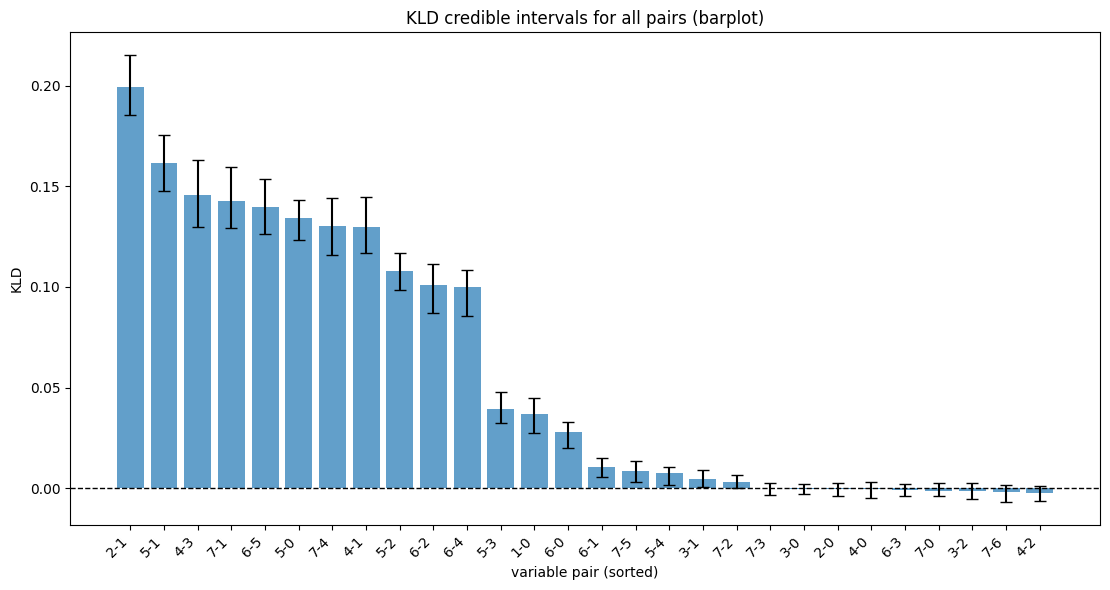

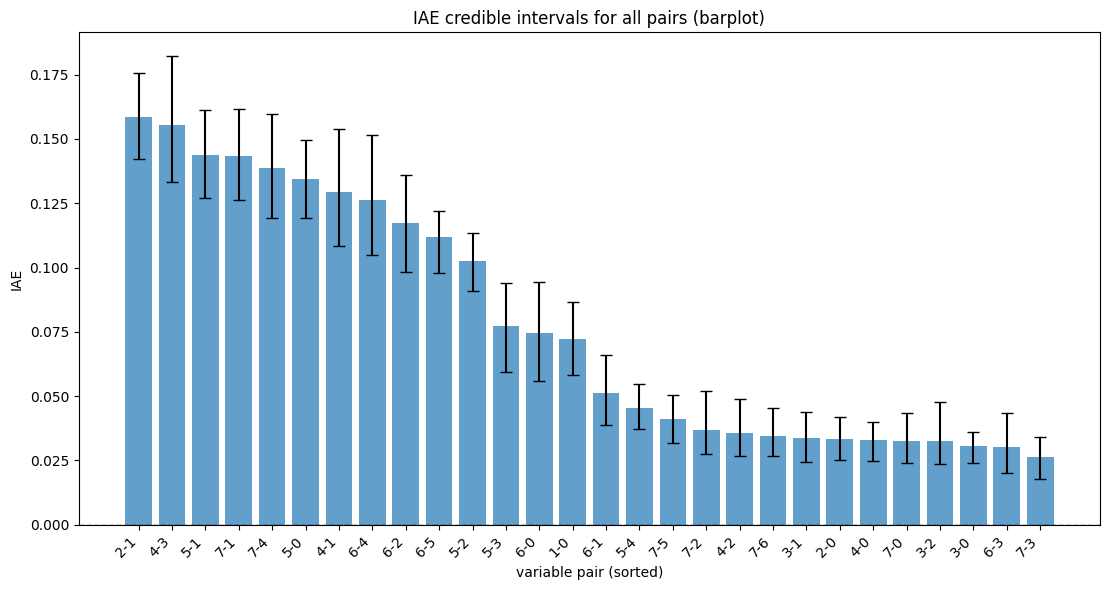

In [26]:
plot_metric_bar_ci(df_ci, metric="kld", log_scale=False)
plot_metric_bar_ci(df_ci, metric="iae", log_scale=False)


In [27]:
#CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

#if CI_groups["transformation"] is not None:
#    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

#if CI_groups["decorrelation"] is not None:
#    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


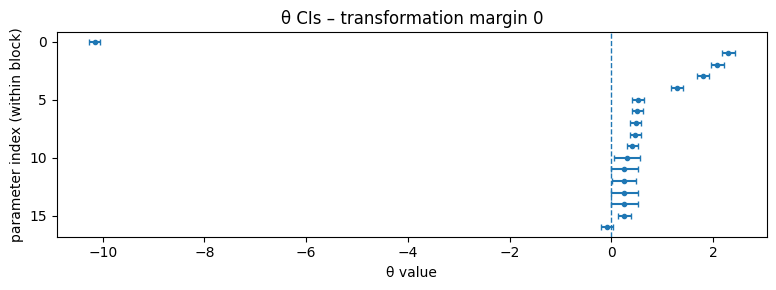

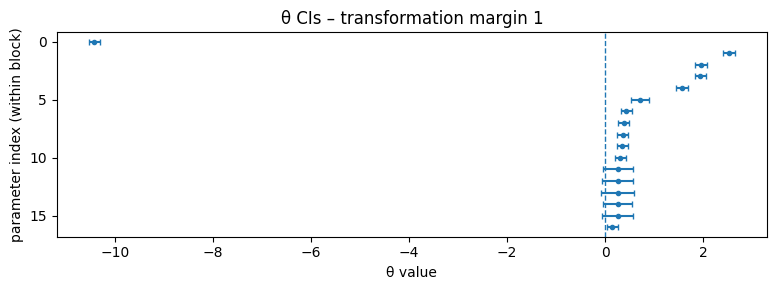

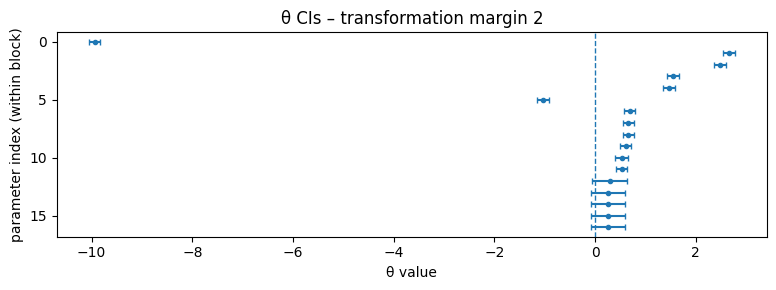

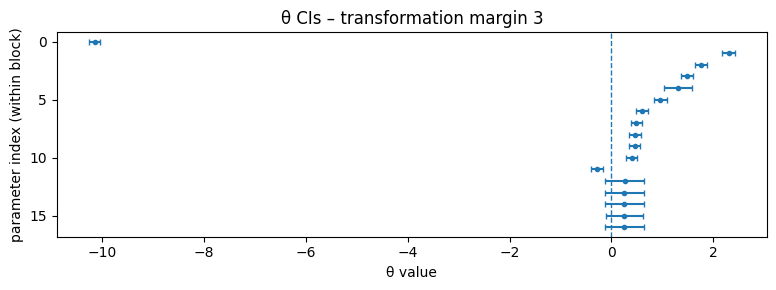

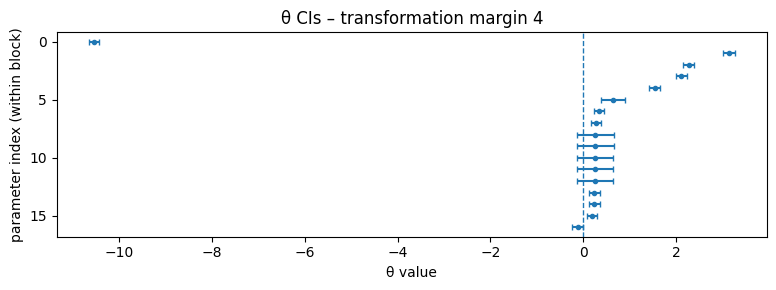

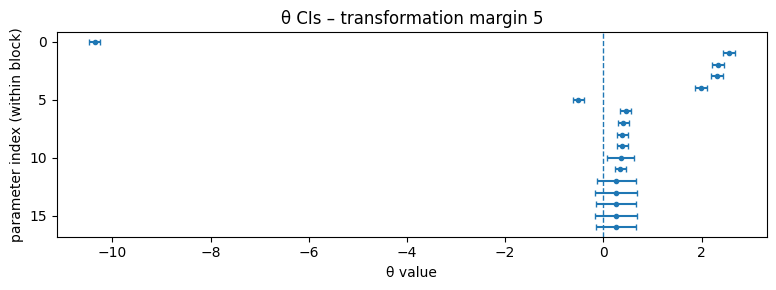

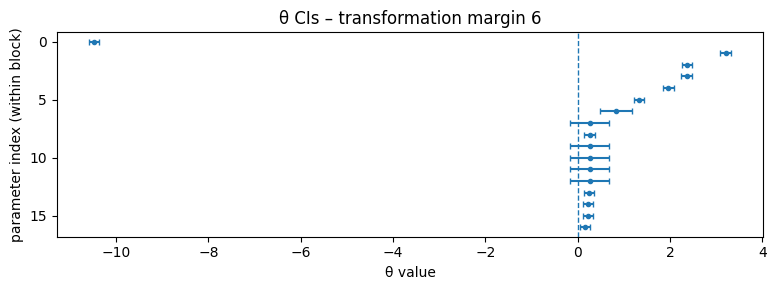

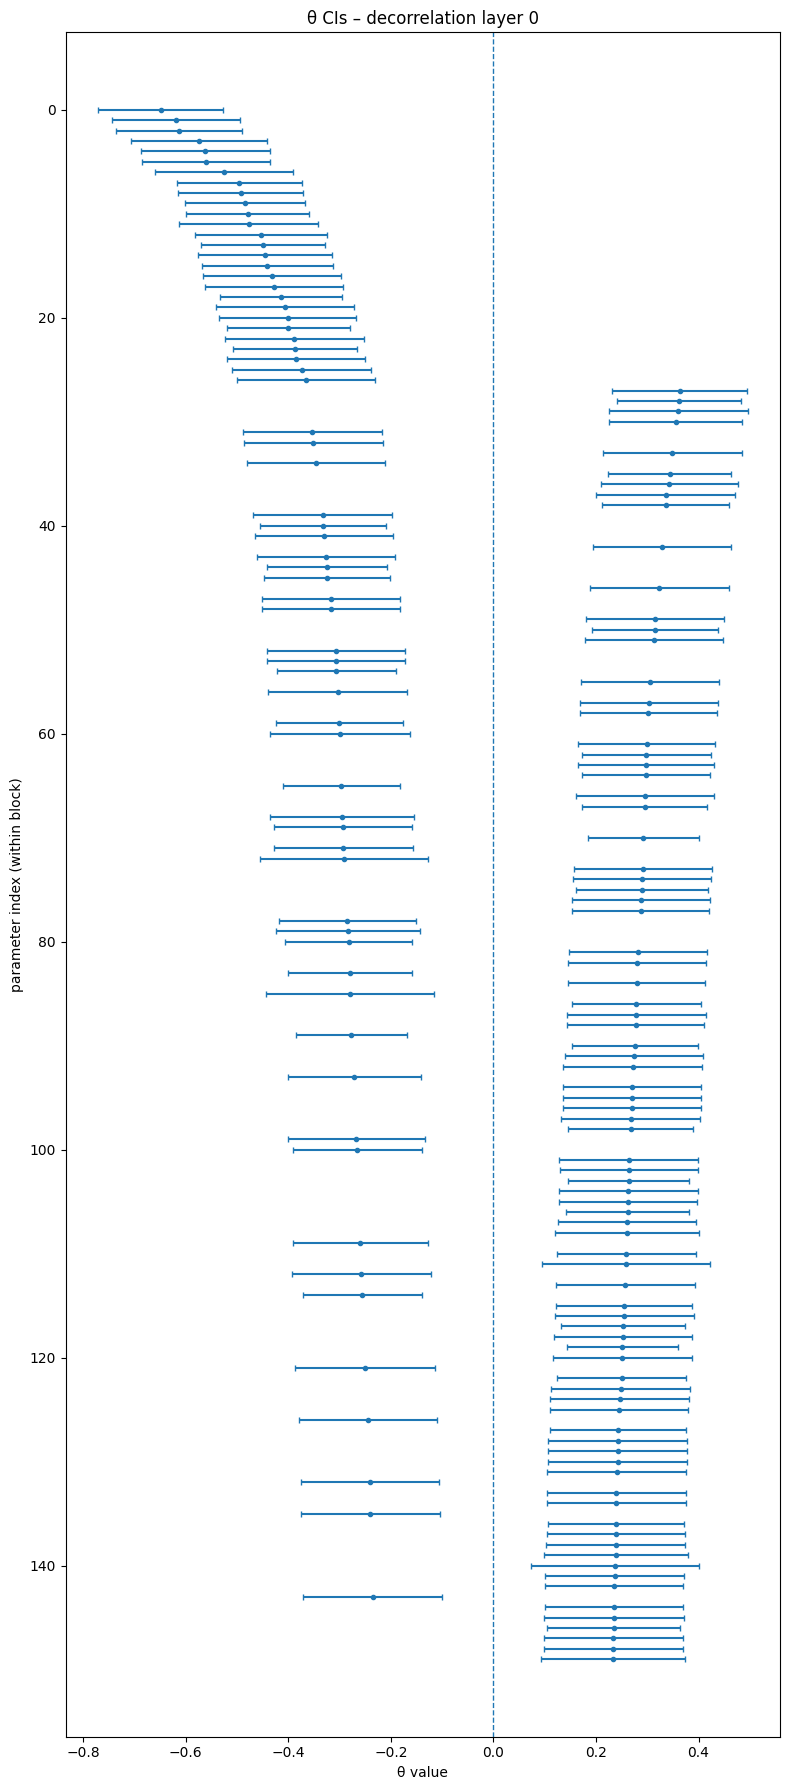

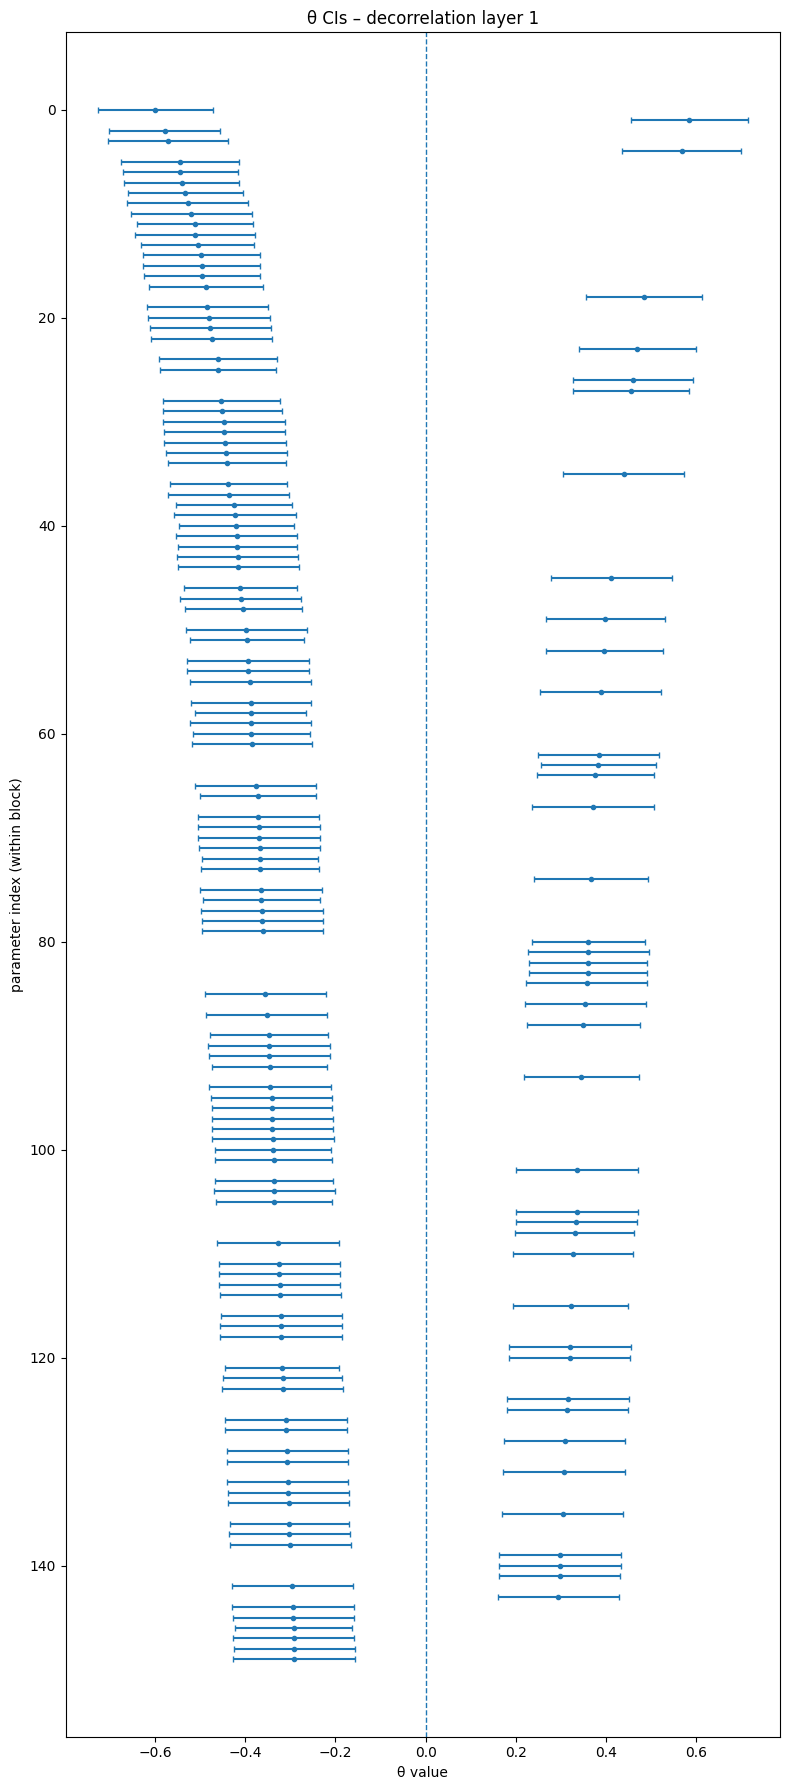

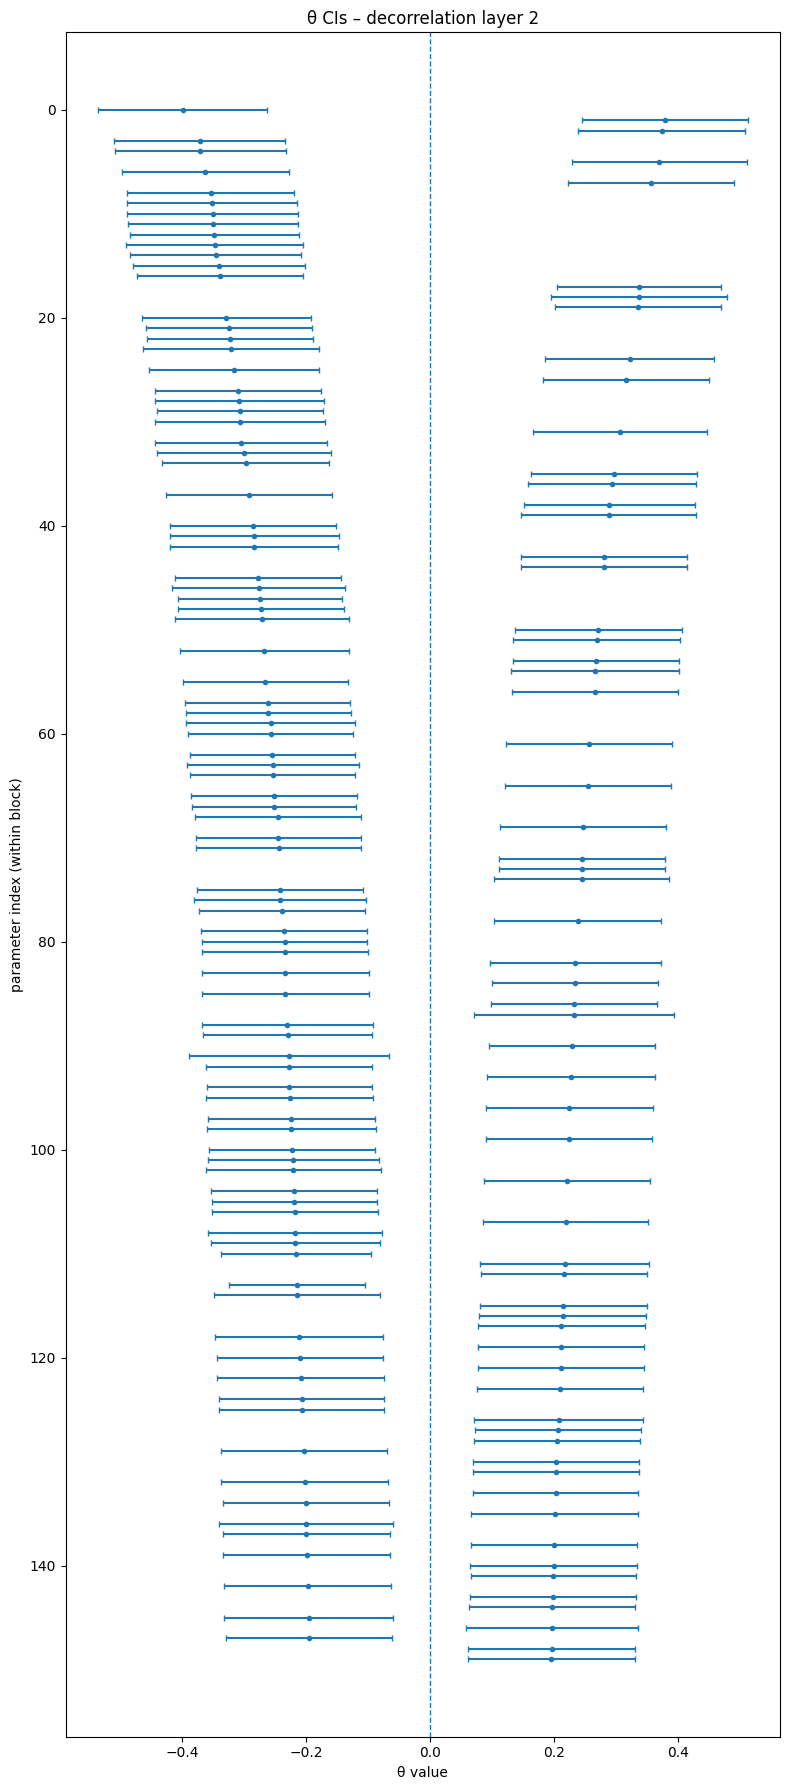

In [28]:
ci_blocks = theta_ci_by_schema(VI, level=0.95, sort_within_group=True)

# Transformation per margin
for j in range(7):
    key = f"transformation.params.{j}"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – transformation margin {j}", max_params=150)

# Decorrelation layers
for ℓ in range(3):
    key = f"decorrelation_layers.{ℓ}.params"
    plot_theta_ci_block(ci_blocks[key], title=f"θ CIs – decorrelation layer {ℓ}", max_params=150)


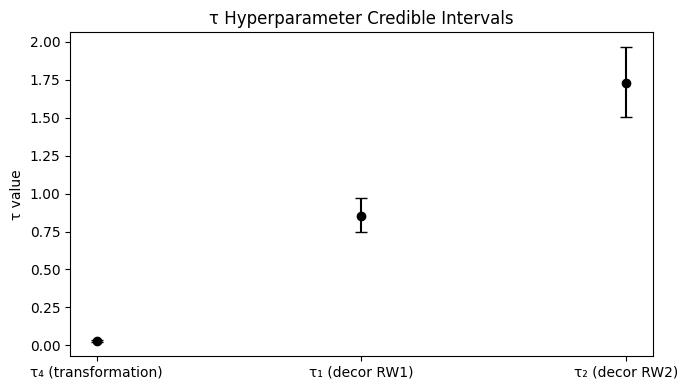

In [29]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [30]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]
[FIX] var 7: valid interval = [-9.999999, 9.999999]


IndexError: list index out of range

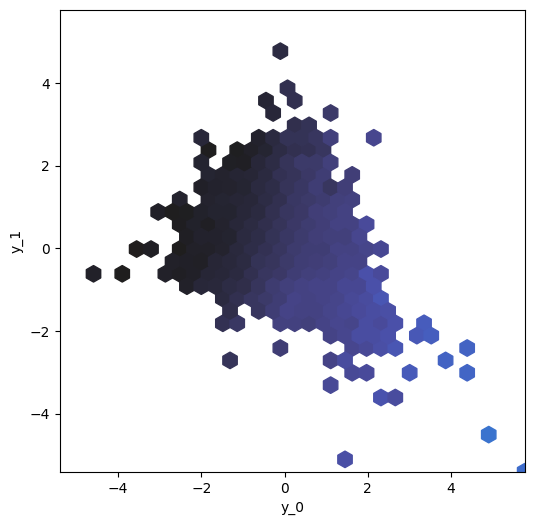

In [32]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

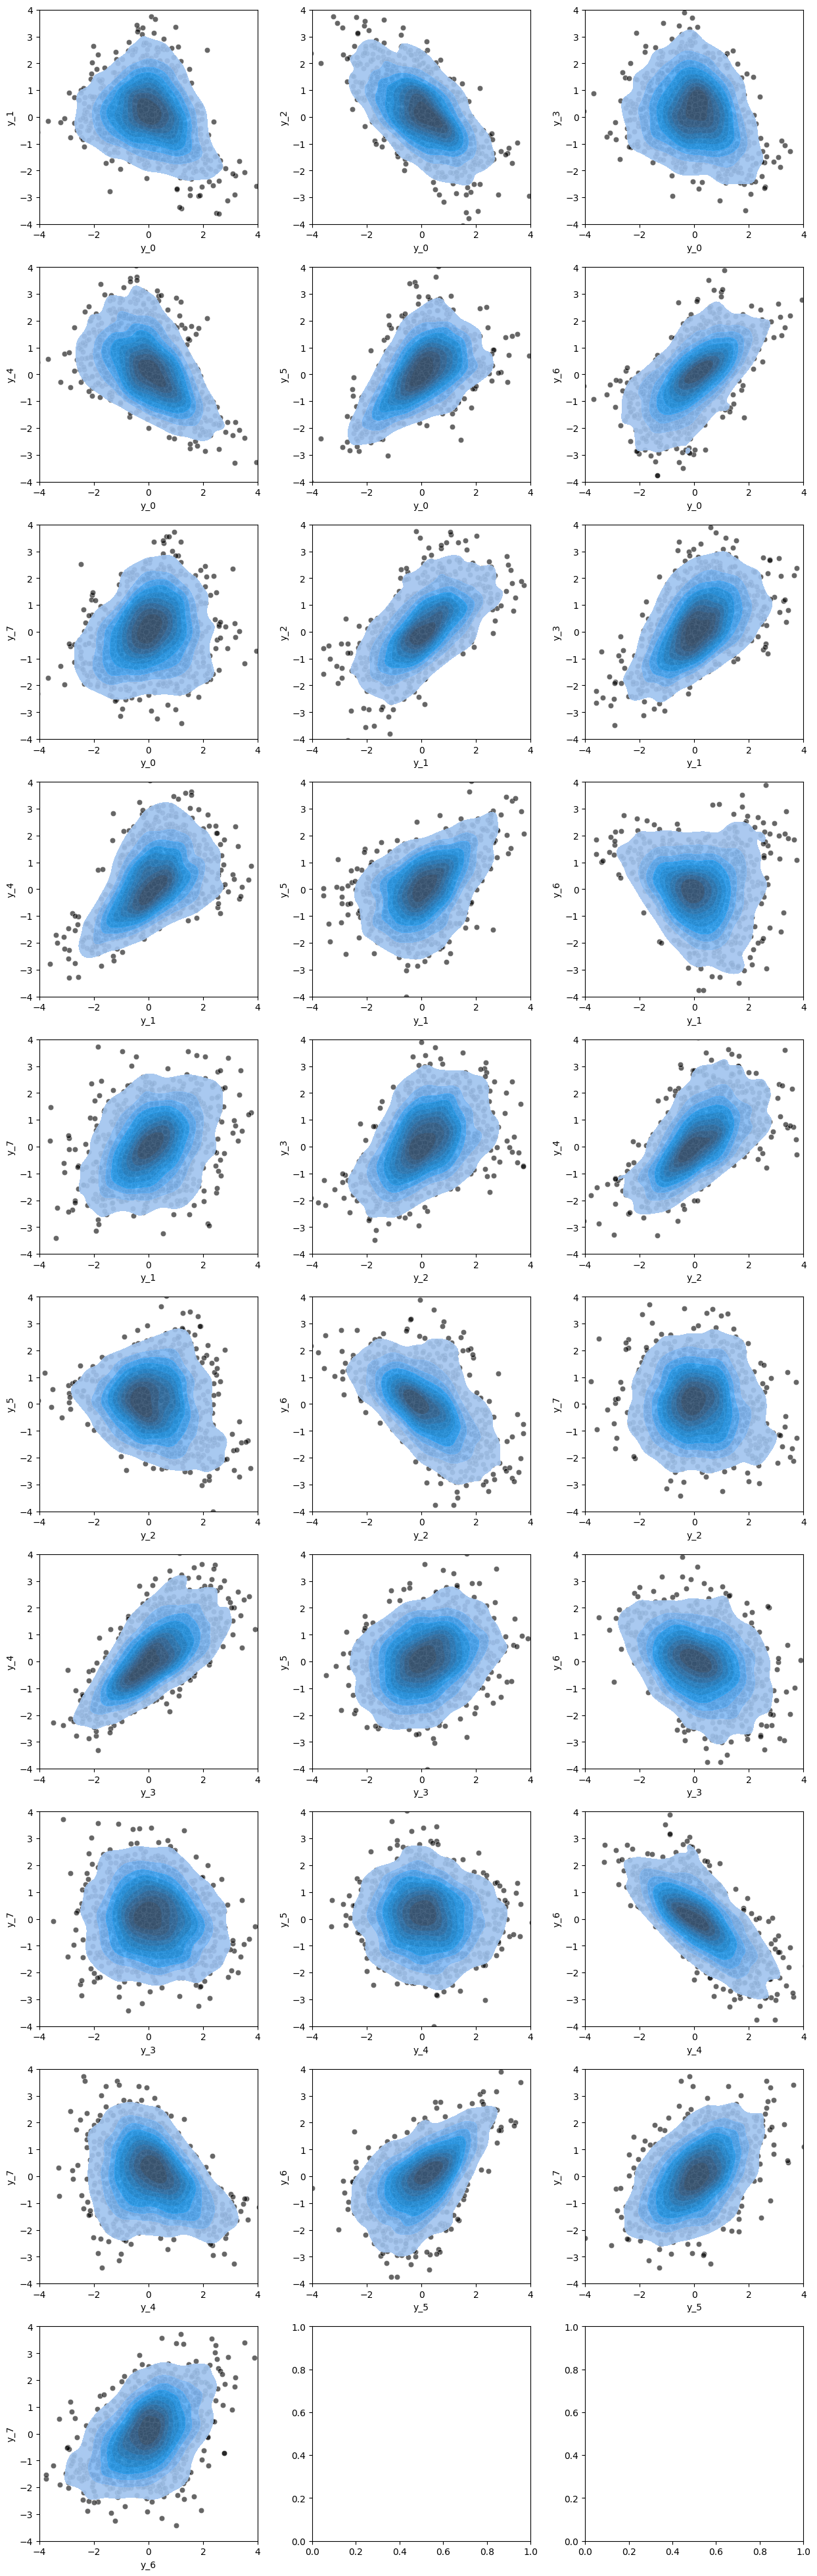

In [33]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [33]:
#model.plot_splines(layer_type="transformation")

In [34]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [35]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [36]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [34]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [38]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [35]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.982607,0.619978,0.032293,0.129721,0.075534,0.072250,0.049808,0.035577,0.040504,...,0.151067,-0.003831,0.068966,-0.026273,-0.041598,-0.036125,-0.001642,-0.011494,0.035577,-0.199469
var_row,0.982607,1.000000,0.470238,0.025345,0.109736,0.049297,0.071857,0.043449,0.030358,0.035372,...,0.149842,-0.010305,0.069908,-0.025067,-0.036207,-0.031751,-0.010584,-0.019775,0.023952,-0.216533
var_col,0.619978,0.470238,1.000000,0.099988,0.138701,0.160704,-0.005013,0.018661,0.005570,0.008634,...,0.122269,0.102494,0.104722,0.029523,0.006127,0.010862,0.078820,0.064894,0.128118,-0.036089
abs_mean,0.032293,0.025345,0.099988,1.000000,-0.384784,0.704433,-0.557745,-0.498632,-0.498632,-0.499726,...,0.941981,0.970991,0.965517,0.922277,0.931034,0.932677,0.943623,0.937055,0.948550,0.598406
mean,0.129721,0.109736,0.138701,-0.384784,1.000000,-0.368363,0.842365,0.879037,0.895457,0.909688,...,-0.340996,-0.411056,-0.367269,-0.425835,-0.435687,-0.420361,-0.370553,-0.368911,-0.366721,-0.429966
std,0.075534,0.049297,0.160704,0.704433,-0.368363,1.000000,-0.692392,-0.668309,-0.656814,-0.642036,...,0.659004,0.629447,0.664477,0.696223,0.711002,0.695676,0.671045,0.674877,0.661193,0.802308
min,0.072250,0.071857,-0.005013,-0.557745,0.842365,-0.692392,1.000000,0.973180,0.964970,0.961686,...,-0.504105,-0.540777,-0.537493,-0.584018,-0.596059,-0.604817,-0.553914,-0.540777,-0.545703,-0.678194
q_1,0.049808,0.043449,0.018661,-0.498632,0.879037,-0.668309,0.973180,1.000000,0.996716,0.991790,...,-0.469075,-0.492063,-0.494253,-0.534209,-0.547893,-0.545156,-0.508484,-0.504652,-0.500274,-0.607272
q_5,0.035577,0.030358,0.005570,-0.498632,0.895457,-0.656814,0.964970,0.996716,1.000000,0.997263,...,-0.466886,-0.497537,-0.491516,-0.532567,-0.546798,-0.534209,-0.498632,-0.493706,-0.494800,-0.598406
q_10,0.040504,0.035372,0.008634,-0.499726,0.909688,-0.642036,0.961686,0.991790,0.997263,1.000000,...,-0.466886,-0.499179,-0.490969,-0.535851,-0.548987,-0.531472,-0.500274,-0.495895,-0.493158,-0.598406


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [36]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8153846153846154
AUC KLD                    : 0.8666666666666667
AUC Conditional Correlation: 0.7897435897435897
AUC Precision Matrix       : 0.8461538461538463


We further print the ROC Curves for different metrics.

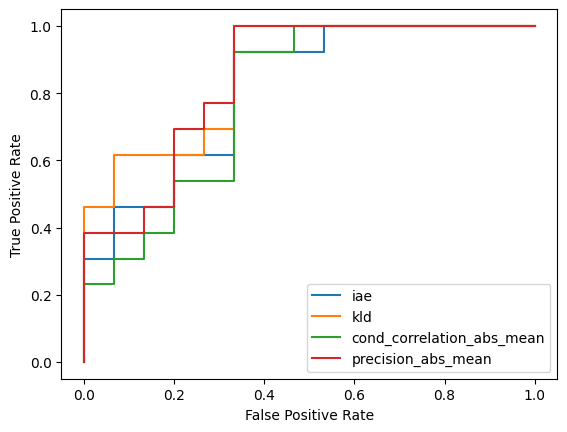

In [37]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()